### Импортируем библиотеки

In [79]:
# pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org lightgbm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [138]:
# pip install matplotlib==3.7.3
# pip show matplotlib
# np.version.version
# '1.26.4'
# Name: matplotlib
# Version: 3.9.2

In [139]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.decomposition import PCA 
import scipy as sp
import seaborn as sns
import math
import sklearn
import re
import matplotlib.pyplot as plt 
from sklearn.cluster import DBSCAN  
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import preprocessing
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
import catboost
import shap
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split
import plotly.express as px
import json
import jsonlines
from sklearn.impute import SimpleImputer
import lightgbm as lgb 
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
%matplotlib inline
np.set_printoptions(precision=4)
# настраиваем показ всех столбцов
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
# формат данных float с одним знаком после запятой
pd.options.display.float_format = '{:,.5f}'.format
# отключим warnings
import warnings
warnings.filterwarnings("ignore")

# Загружаем данные

In [140]:
macro_data = pd.read_csv('/home/sigma.sbrf.ru@19229892/Рабочий стол/sberbank-russian-housing-market/macro.csv')
data_train = pd.read_csv('/home/sigma.sbrf.ru@19229892/Рабочий стол/sberbank-russian-housing-market/train.csv/train.csv')
X_check = pd.read_csv('/home/sigma.sbrf.ru@19229892/Рабочий стол/sberbank-russian-housing-market/test.csv/test.csv')

### Удаляем столбцы с id, так как это идентификаторы и они не представляют значимости для модели

In [141]:
data_train = data_train.drop(['ID_metro',
 'ID_railroad_station_walk',
 'ID_railroad_station_avto',
 'ID_big_road1',
 'ID_big_road2',
 'ID_railroad_terminal',
 'ID_bus_terminal', 'id'], axis=1)

# Предварительно сохраняем id для выборки без разметки
id_check = X_check['id']

X_check = X_check.drop(['ID_metro',
 'ID_railroad_station_walk',
 'ID_railroad_station_avto',
 'ID_big_road1',
 'ID_big_road2',
 'ID_railroad_terminal',
 'ID_bus_terminal', 'id'], axis=1)

### Проверяем пропущенные значения, выводим данные в процентах.

In [142]:
percent_of_nans_by_columns = pd.DataFrame(data_train.isnull().sum()/ len(data_train) * 100, columns =['count_nans'])
percent_of_nans_by_columns.sort_values(by = 'count_nans', ascending = False)[:10]

,count_nans
hospital_beds_raion,47.39260
build_year,44.64901
state,44.49805
cafe_avg_price_500,43.58570
cafe_sum_500_min_price_avg,43.58570
cafe_sum_500_max_price_avg,43.58570
max_floor,31.41348
material,31.41348
num_room,31.41348
kitch_sq,31.41348


In [143]:
percent_of_nans_by_columns = pd.DataFrame(X_check.isnull().sum()/ len(X_check) * 100, columns =['count_nans'])
percent_of_nans_by_columns.sort_values(by = 'count_nans', ascending = False)[:10]

,count_nans
hospital_beds_raion,44.60976
cafe_avg_price_500,41.22944
cafe_sum_500_max_price_avg,41.22944
cafe_sum_500_min_price_avg,41.22944
preschool_quota,20.83007
school_quota,20.81702
cafe_sum_1000_max_price_avg,15.94884
cafe_sum_1000_min_price_avg,15.94884
cafe_avg_price_1000,15.94884
raion_build_count_with_material_info,15.89663


In [144]:
percent_of_nans_by_columns = pd.DataFrame(macro_data.isnull().sum()/ len(macro_data) * 100, columns =['count_nans'])
percent_of_nans_by_columns.sort_values(by = 'count_nans', ascending = False)[:10]

,count_nans
provision_retail_space_modern_sqm,70.61192
provision_retail_space_sqm,70.57166
modern_education_share,55.91787
old_education_build_share,55.91787
hospital_beds_available_per_cap,41.18357
hospital_bed_occupancy_per_year,41.18357
load_of_teachers_preschool_per_teacher,41.18357
grp_growth,41.18357
theaters_viewers_per_1000_cap,41.18357
museum_visitis_per_100_cap,41.18357


### Пропущенные значения присутствуют, но не в очень большом количестве. Удалять столбцы не будем, будем заполнять пропуски.

# Рассмотрим корреляцию целевого признака с другими

In [145]:
corrs = data_train.corr(method='pearson')
corr_with_prices = corrs["price_doc"][:-1]
corr_with_prices[abs(corr_with_prices).argsort()[::-1]].tail(100)

cafe_count_1000                          0.10584
cafe_sum_1500_min_price_avg              0.10464
big_road1_km                            -0.10374
cafe_sum_2000_max_price_avg              0.10299
school_education_centers_top_20_raion    0.10228
                                          ...   
cafe_sum_3000_min_price_avg              0.00512
cafe_avg_price_3000                      0.00334
cafe_sum_3000_max_price_avg              0.00220
build_year                               0.00216
trc_sqm_500                              0.00037
Name: price_doc, Length: 100, dtype: float64

In [146]:
# видим, что есть признаки с очень слабой корреляцией

In [147]:
corrs = data_train.corr(method='pearson')
corr_with_prices = corrs["price_doc"][:-1]
corr_with_prices[abs(corr_with_prices).argsort()[::-1]].head(10)

num_room              0.47634
full_sq               0.34184
sport_count_5000      0.29486
sport_count_3000      0.29065
trc_count_5000        0.28937
zd_vokzaly_avto_km   -0.28407
sadovoe_km           -0.28362
kremlin_km           -0.27925
bulvar_ring_km       -0.27916
sport_count_2000      0.27806
Name: price_doc, dtype: float64

In [148]:
# видим, что есть признаков с корреляцией больше 0.8 нет

In [149]:
toDelete = list(corr_with_prices[abs(corr_with_prices).argsort()[::-1]].tail(100).index)
print(toDelete[0], toDelete[-1]) # Убеждаемся, что взяли те признаки

cafe_count_1000 trc_sqm_500


# Удалим слабо скоррелированные признаки (берем по модулю менее 1.13)

In [150]:
print(data_train.shape, '\n', X_check.shape)

for col in toDelete:
    data_train.drop(col, axis=1, inplace=True)
    X_check.drop(col, axis=1, inplace=True)

print(data_train.shape, '\n', X_check.shape)

(30471, 284) 
 (7662, 283)
(30471, 184) 
 (7662, 183)


# Сформируем список столбцов с пропусками

In [151]:
missingValues = data_train.columns[data_train.isnull().any()].tolist()

pd.isnull(data_train[missingValues]).sum().sort_values(ascending=False)

hospital_beds_raion            14441
state                          13559
num_room                        9572
life_sq                         6383
build_count_brick               4991
build_count_monolith            4991
cafe_sum_1500_max_price_avg     4199
cafe_avg_price_1500             4199
floor                            167
metro_min_walk                    25
metro_km_walk                     25
railroad_station_walk_km          25
railroad_station_walk_min         25
dtype: int64

In [152]:
cols_fillna_mode = ['floor',
 'product_type',
 'num_room',
 'state',
 'hospital_beds_raion',
 'build_count_brick',
 'build_count_monolith',
 'green_part_2000']

cols_fillna_mean = ['life_sq',
 'metro_min_walk',
 'metro_km_walk',
 'railroad_station_walk_km',
 'railroad_station_walk_min',
 'cafe_sum_1500_max_price_avg',
 'cafe_avg_price_1500']

In [153]:
for col in cols_fillna_mode:
    data_train[col].fillna(data_train[col].mode().iloc[0],inplace=True)
    X_check[col].fillna(data_train[col].mode().iloc[0],inplace=True)

for col in cols_fillna_mean:
    data_train[col].fillna(data_train[col].mean(),inplace=True)
    X_check[col].fillna(data_train[col].mean(),inplace=True)

In [154]:
missingValues_macro = macro_data.columns[macro_data.isnull().any()].tolist()

pd.isnull(macro_data[missingValues_macro]).sum().sort_values(ascending=False)

provision_retail_space_modern_sqm    1754
provision_retail_space_sqm           1753
modern_education_share               1389
old_education_build_share            1389
theaters_viewers_per_1000_cap        1023
                                     ... 
micex_rgbi_tr                          10
brent                                   3
eurrub                                  3
usdrub                                  3
micex_cbi_tr                            1
Length: 91, dtype: int64

In [155]:
cols_fillna_mean_macro = ['provision_retail_space_modern_sqm',
 'provision_retail_space_sqm',
 'modern_education_share',
 'old_education_build_share',
 'theaters_viewers_per_1000_cap',
 'grp_growth',
 'load_of_teachers_preschool_per_teacher',
 'students_reg_sports_share',
 'population_reg_sports_share',
 'museum_visitis_per_100_cap',
  'hospital_bed_occupancy_per_year',
  'hospital_beds_available_per_cap',
  'invest_fixed_assets_phys',
  'pop_migration',
  'baths_share']

In [156]:
for col in cols_fillna_mean_macro:
    macro_data[col].fillna(macro_data[col].mode().iloc[0],inplace=True)

In [157]:
missingValues_macro = macro_data.columns[macro_data.isnull().any()].tolist()

pd.isnull(macro_data[missingValues_macro]).sum().sort_values(ascending=False)

divorce_rate             658
hot_water_share          658
share_own_revenues       658
overdue_wages_per_cap    658
fin_res_per_cap          658
                        ... 
micex_rgbi_tr             10
eurrub                     3
brent                      3
usdrub                     3
micex_cbi_tr               1
Length: 76, dtype: int64

### Заменяем некорректные символы на 0

In [158]:
# благодаря этому можно обработать данные в столбце как числовой признак
macro_data['child_on_acc_pre_school'] = macro_data['child_on_acc_pre_school'].replace('#!', 0)

In [159]:
# проверяем наличие некорректного символа после удаления
macro_data[macro_data['child_on_acc_pre_school']=='#!']

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,eurrub,brent,net_capital_export,gdp_annual,gdp_annual_growth,average_provision_of_build_contract,average_provision_of_build_contract_moscow,rts,micex,micex_rgbi_tr,micex_cbi_tr,deposits_value,deposits_growth,deposits_rate,mortgage_value,mortgage_growth,mortgage_rate,grp,grp_growth,income_per_cap,real_dispos_income_per_cap_growth,salary,salary_growth,fixed_basket,retail_trade_turnover,retail_trade_turnover_per_cap,retail_trade_turnover_growth,labor_force,unemployment,employment,invest_fixed_capital_per_cap,invest_fixed_assets,profitable_enterpr_share,unprofitable_enterpr_share,share_own_revenues,overdue_wages_per_cap,fin_res_per_cap,marriages_per_1000_cap,divorce_rate,construction_value,invest_fixed_assets_phys,pop_natural_increase,pop_migration,pop_total_inc,childbirth,mortality,housing_fund_sqm,lodging_sqm_per_cap,water_pipes_share,baths_share,sewerage_share,gas_share,hot_water_share,electric_stove_share,heating_share,old_house_share,average_life_exp,infant_mortarity_per_1000_cap,perinatal_mort_per_1000_cap,incidence_population,rent_price_4+room_bus,rent_price_3room_bus,rent_price_2room_bus,rent_price_1room_bus,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,load_of_teachers_preschool_per_teacher,child_on_acc_pre_school,load_of_teachers_school_per_teacher,students_state_oneshift,modern_education_share,old_education_build_share,provision_doctors,provision_nurse,load_on_doctors,power_clinics,hospital_beds_available_per_cap,hospital_bed_occupancy_per_year,provision_retail_space_sqm,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm


### Заменяем тип данных для столбца 'child_on_acc_pre_school'
Благодаря этому можно обработать данные в столбце как числовой признак

In [160]:
macro_data['child_on_acc_pre_school']

0       45,713
1       45,713
2       45,713
3       45,713
4       45,713
         ...  
2479       NaN
2480       NaN
2481       NaN
2482       NaN
2483       NaN
Name: child_on_acc_pre_school, Length: 2484, dtype: object

In [161]:
macro_data['child_on_acc_pre_school'] = macro_data['child_on_acc_pre_school'].str.replace(',', '').astype(float)
# data_train_with_macro['child_on_acc_pre_school'] = data_train_with_macro['child_on_acc_pre_school'].round(1)

In [162]:
# проверяем, что тип данных изменился
macro_data['child_on_acc_pre_school']

0      45,713.00000
1      45,713.00000
2      45,713.00000
3      45,713.00000
4      45,713.00000
           ...     
2479            NaN
2480            NaN
2481            NaN
2482            NaN
2483            NaN
Name: child_on_acc_pre_school, Length: 2484, dtype: float64

### Исправляем явные ошибки в данных

In [163]:
# ошибка, указано 33 вместо 3. Исправляем на 3.
data_train.loc[data_train['state'] == 33, 'state'] = 3

# # build_year has an erronus value 20052009. Since its unclear which it should be, let's replace with 2007
# data_train.loc[data_train['build_year'] == 20052009, 'build_year'] = 2007

# Смотрим описание данных

In [164]:
data_train.describe()

,full_sq,life_sq,floor,num_room,state,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,shopping_centers_raion,office_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road2_km,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
count,"30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30,471.00000","30

#### В датасете имеются категориальные данные, числовые данные и данные в формате даты.
#### EDA будет производиться в зависимости от типа данных.

# Проверяем распределение целевой переменной

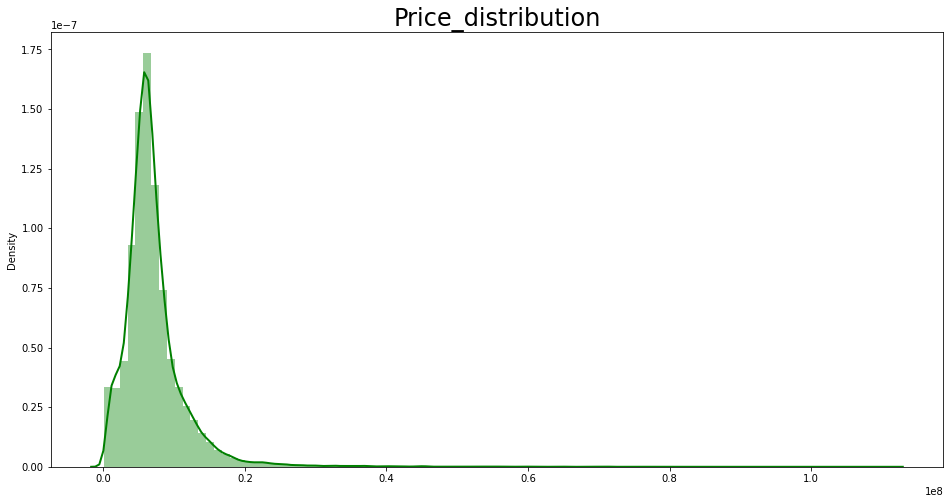

In [165]:
fig, ax = plt.subplots(figsize=(16,8))
sns.distplot(data_train['price_doc'].values
             , bins=100
             , color = 'green'
             , kde = True
             , kde_kws={'linewidth': 2})
# plt.plot(data_train_with_macro['price_doc'].values, kde=True)
plt.title('Price_distribution', fontsize=24)
plt.show()

# Распределение не является нормальным, присутствует сильное смещение. В таком случае стоит применить логарифмирование целевой переменной.

Логарифмирование в машинном обучении применяют в следующих случаях:

1. Для нормализации данных. Для алгоритмов машинного обучения важно, чтобы данные были нормально распределены, чтобы обеспечить лучшую производительность. Логарифмирование позволяет преобразовать данные в более нормальное распределение, что упрощает их анализ и моделирование. 
2. Для снижения влияния выбросов. Выбросы могут значительно влиять на алгоритмы машинного обучения, приводя к предвзятым моделям. Логарифмирование сжимает большие значения, что упрощает построение модели, в которой не доминируют экстремальные значения. 
3. Для преобразования данных для определённых видов анализа. Логарифмирование уменьшает диапазон значений и сжимает большие значения, что облегчает анализ данных с большими вариациями. 

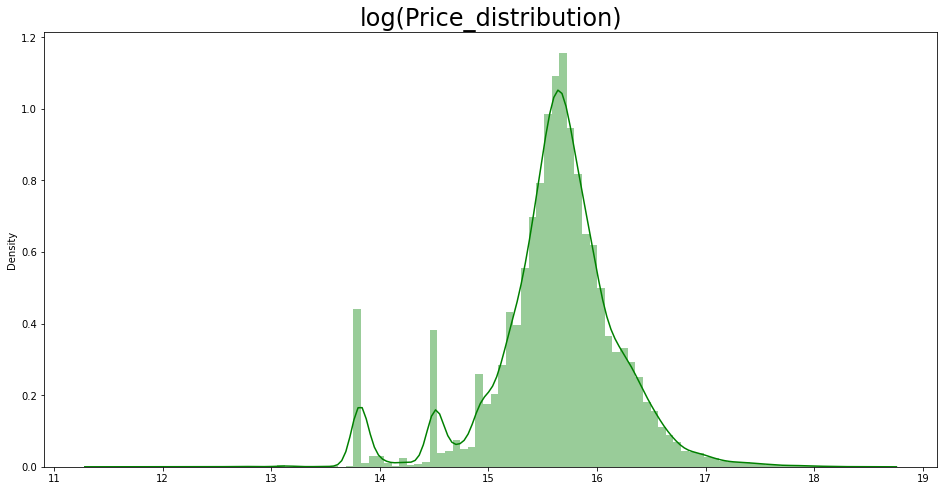

In [166]:
fig, ax = plt.subplots(figsize=(16,8))
sns.distplot(np.log(data_train['price_doc']).values, color = 'green', bins=100, kde=True, ax=ax)
plt.title('log(Price_distribution)', fontsize=24)
plt.show()

### Посмотрим на распределение фичи area_m 

In [167]:
# fig, ax = plt.subplots(figsize=(16,8))
# sns.distplot(data_train['area_m'].values
#              , bins=100
#              , color = 'green'
#              , kde = True
#              , kde_kws={'linewidth': 2})
# # plt.plot(data_train_with_macro['price_doc'].values, kde=True)
# plt.title('area_m_distribution', fontsize=14)
# plt.show()

### Посмотрим на график после логарифмирования фичи area_m 

In [168]:
# fig, ax = plt.subplots(figsize=(16,8))
# sns.distplot(np.log(data_train['area_m']).values, color = 'green', bins=100, kde=True, ax=ax)
# plt.title('log(area_m_distribution)', fontsize=14)
# plt.show()

# Объединяем с макроэкономическими показателями

In [169]:
# data_train = data_train.merge(macro_data, on='timestamp')
# X_check = X_check.merge(macro_data, on='timestamp')
# data_train_with_macro = data_train.merge(macro_data, on='timestamp', suffixes=('_', '_macro'))
# X_check_with_macro = X_check.merge(macro_data, on='timestamp', suffixes=('_', '_macro'))

In [170]:
# data_train

## EDA для данных в формате даты

In [171]:
def EDA_for_date_features(data):
    """переводим данные о дате в нужный формат"""
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['month'] = data.timestamp.dt.month
    data['year'] = data.timestamp.dt.year
    return data

In [172]:
data = EDA_for_date_features(data_train)

In [173]:
data_train_without_timestamp = data_train.drop('timestamp', axis=1)

In [174]:
data_train_without_timestamp

,full_sq,life_sq,floor,num_room,state,product_type,sub_area,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,month,year
0,43,27.00000,4.00000,2.00000,2.00000,Investment,Bibirevo,"6,407,578.10000",155572,9576,5,10309,5,240.00000,1,0,7,no,16,1,no,no,no,no,no,no,no,no,21154,11007,10147,98207,52277,45930,36211,10580,25631,9576,4899,4677,10309,5463,4846,23603,12286,11317,18654,9709,8945,0.00000,2.00000,2.59024,1.13126,13.57512,1.13126,0.14570,0.17798,2.15859,5.41989,65.03872,5.41989,6.90589,0.27499,3.29982,no,10.91859,13.10062,13.67566,15.15621,no,3.83095,no,14.23196,24.29241,18.15234,5.71852,1.21003,1.06251,5.81413,4.30813,1.67626,0.48584,3.06505,1.10759,8.14859,3.51651,2.39235,4.24804,0.97474,6.71503,0.88435,0.64849,0.63719,0.94796,0.17798,0.62578,0.62819,3.93204,14.05305,7.38950,7.02370,0.51684,good,0,0,0,0,0,0,1,30500,1,4,3,0,6,3,39554,9,34,969.70

In [175]:
# data_train_without_timestamp['sub_area'].unique()

In [176]:
def EDA_for_date_features_check(data_checked):
    ### переводим данные о дате в нужный формат
    data_checked['timestamp'] = pd.to_datetime(data_checked['timestamp'])
    data_checked['month'] = data_checked.timestamp.dt.month
    data_checked['year'] = data_checked.timestamp.dt.year
    return data_checked

In [177]:
data_checked = EDA_for_date_features_check(X_check)

In [178]:
data_checked_without_timestamp = data_checked.drop('timestamp', axis=1)

In [179]:
data_checked_without_timestamp

,full_sq,life_sq,floor,num_room,state,product_type,sub_area,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,month,year
0,39.00000,20.70000,2,1,3.00000,Investment,Juzhnoe Butovo,"26,155,137.04000",178264,14080,11,14892,13,540.00000,1,0,13,no,4,4,no,no,no,no,no,no,no,no,30808,16251,14557,121369,59138,62231,26087,7410,18677,14080,7457,6623,14892,7839,7053,34341,18094,16247,27123,14340,12783,245.00000,116.00000,1.25896,0.73591,8.83090,0.73591,0.07850,0.74696,2.04849,4.81210,57.74522,4.85075,6.27496,0.11413,1.36960,no,19.65110,22.79099,24.07971,24.77908,no,5.70648,no,27.55349,8.42496,22.62436,16.22408,6.62008,4.12187,8.95778,8.82406,5.35367,0.22579,3.67394,11.81084,20.39243,9.13198,3.30012,25.46274,1.61315,17.21487,7.92261,2.41414,4.92361,0.51421,0.74696,0.74914,0.84830,1.91774,19.95341,14.05221,12.22858,0.44632,satisfactory,0,0,1,0,1,0,0,0,0,0,2,0,3,0,0,0,2,"

In [180]:
index_area = data_train_without_timestamp[data_train_without_timestamp['sub_area'] == 'Poselenie Klenovskoe'].index
data_train_without_timestamp.drop(index_area , inplace=True)

In [181]:
data_train_without_timestamp

,full_sq,life_sq,floor,num_room,state,product_type,sub_area,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,month,year
0,43,27.00000,4.00000,2.00000,2.00000,Investment,Bibirevo,"6,407,578.10000",155572,9576,5,10309,5,240.00000,1,0,7,no,16,1,no,no,no,no,no,no,no,no,21154,11007,10147,98207,52277,45930,36211,10580,25631,9576,4899,4677,10309,5463,4846,23603,12286,11317,18654,9709,8945,0.00000,2.00000,2.59024,1.13126,13.57512,1.13126,0.14570,0.17798,2.15859,5.41989,65.03872,5.41989,6.90589,0.27499,3.29982,no,10.91859,13.10062,13.67566,15.15621,no,3.83095,no,14.23196,24.29241,18.15234,5.71852,1.21003,1.06251,5.81413,4.30813,1.67626,0.48584,3.06505,1.10759,8.14859,3.51651,2.39235,4.24804,0.97474,6.71503,0.88435,0.64849,0.63719,0.94796,0.17798,0.62578,0.62819,3.93204,14.05305,7.38950,7.02370,0.51684,good,0,0,0,0,0,0,1,30500,1,4,3,0,6,3,39554,9,34,969.70

In [182]:
numerical_features = data_train_without_timestamp.dtypes[data_train_without_timestamp.dtypes != "object"].index
categorical_features = data_train_without_timestamp.dtypes[data_train_without_timestamp.dtypes == "object"].index

print("Кол-во количественных признаков: ", len(numerical_features))
print("Кол-во категориальных признаков: ", len(categorical_features))

Кол-во количественных признаков:  170
Кол-во категориальных признаков:  15


In [183]:
data_train_without_timestamp.isna().sum().sort_values(ascending=False)

full_sq                        0
cafe_count_1500_price_high     0
trc_count_1500                 0
cafe_count_1500                0
cafe_sum_1500_max_price_avg    0
                              ..
water_1line                    0
ttk_km                         0
sadovoe_km                     0
bulvar_ring_km                 0
year                           0
Length: 185, dtype: int64

In [184]:
data_train_without_timestamp

,full_sq,life_sq,floor,num_room,state,product_type,sub_area,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,month,year
0,43,27.00000,4.00000,2.00000,2.00000,Investment,Bibirevo,"6,407,578.10000",155572,9576,5,10309,5,240.00000,1,0,7,no,16,1,no,no,no,no,no,no,no,no,21154,11007,10147,98207,52277,45930,36211,10580,25631,9576,4899,4677,10309,5463,4846,23603,12286,11317,18654,9709,8945,0.00000,2.00000,2.59024,1.13126,13.57512,1.13126,0.14570,0.17798,2.15859,5.41989,65.03872,5.41989,6.90589,0.27499,3.29982,no,10.91859,13.10062,13.67566,15.15621,no,3.83095,no,14.23196,24.29241,18.15234,5.71852,1.21003,1.06251,5.81413,4.30813,1.67626,0.48584,3.06505,1.10759,8.14859,3.51651,2.39235,4.24804,0.97474,6.71503,0.88435,0.64849,0.63719,0.94796,0.17798,0.62578,0.62819,3.93204,14.05305,7.38950,7.02370,0.51684,good,0,0,0,0,0,0,1,30500,1,4,3,0,6,3,39554,9,34,969.70

## EDA для категориальных фичей

### Удаляем лишние пробелы справа и слева от каждого значения 

In [185]:
data_train_without_timestamp = data_train_without_timestamp.applymap(lambda x: x.strip() if isinstance(x, str) else x)
data_checked_without_timestamp = data_checked_without_timestamp.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [186]:
data_train_without_timestamp.replace(to_replace=['no', 'yes'], value=[0, 1], inplace = True)
# data_train_without_timestamp['product_type'].replace(to_replace=['nan'], value=['Investment'], inplace = True)
data_train_without_timestamp['ecology'].replace(to_replace=['no data'], value=['poor'], inplace = True)
# data_train_without_timestamp['product_type'].unique()

In [187]:
data_train_without_timestamp

,full_sq,life_sq,floor,num_room,state,product_type,sub_area,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,month,year
0,43,27.00000,4.00000,2.00000,2.00000,Investment,Bibirevo,"6,407,578.10000",155572,9576,5,10309,5,240.00000,1,0,7,0,16,1,0,0,0,0,0,0,0,0,21154,11007,10147,98207,52277,45930,36211,10580,25631,9576,4899,4677,10309,5463,4846,23603,12286,11317,18654,9709,8945,0.00000,2.00000,2.59024,1.13126,13.57512,1.13126,0.14570,0.17798,2.15859,5.41989,65.03872,5.41989,6.90589,0.27499,3.29982,0,10.91859,13.10062,13.67566,15.15621,0,3.83095,0,14.23196,24.29241,18.15234,5.71852,1.21003,1.06251,5.81413,4.30813,1.67626,0.48584,3.06505,1.10759,8.14859,3.51651,2.39235,4.24804,0.97474,6.71503,0.88435,0.64849,0.63719,0.94796,0.17798,0.62578,0.62819,3.93204,14.05305,7.38950,7.02370,0.51684,good,0,0,0,0,0,0,1,30500,1,4,3,0,6,3,39554,9,34,969.70000,768.1800

In [188]:
data_train_without_timestamp

,full_sq,life_sq,floor,num_room,state,product_type,sub_area,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,month,year
0,43,27.00000,4.00000,2.00000,2.00000,Investment,Bibirevo,"6,407,578.10000",155572,9576,5,10309,5,240.00000,1,0,7,0,16,1,0,0,0,0,0,0,0,0,21154,11007,10147,98207,52277,45930,36211,10580,25631,9576,4899,4677,10309,5463,4846,23603,12286,11317,18654,9709,8945,0.00000,2.00000,2.59024,1.13126,13.57512,1.13126,0.14570,0.17798,2.15859,5.41989,65.03872,5.41989,6.90589,0.27499,3.29982,0,10.91859,13.10062,13.67566,15.15621,0,3.83095,0,14.23196,24.29241,18.15234,5.71852,1.21003,1.06251,5.81413,4.30813,1.67626,0.48584,3.06505,1.10759,8.14859,3.51651,2.39235,4.24804,0.97474,6.71503,0.88435,0.64849,0.63719,0.94796,0.17798,0.62578,0.62819,3.93204,14.05305,7.38950,7.02370,0.51684,good,0,0,0,0,0,0,1,30500,1,4,3,0,6,3,39554,9,34,969.70000,768.1800

In [189]:
data_checked_without_timestamp.replace(to_replace=['no', 'yes'], value=[0, 1], inplace = True)
# mode_product_type = data_checked_without_timestamp['product_type'].mode()  # [0] Вычисление моды (наиболее часто встречающегося значения)
data_checked_without_timestamp['product_type'].fillna('Investment', inplace=True)
data_checked_without_timestamp['ecology'].replace(to_replace=['no data'], value=['poor'], inplace = True)

# imputer_no_data = SimpleImputer(missing_values='no data', strategy='most_frequent')
# data_checked_without_timestamp = pd.DataFrame(imputer_no_data.fit_transform(data_checked_without_timestamp['ecology']))
# data_checked_without_timestamp['product_type'].unique()

In [190]:
data_checked_without_timestamp

,full_sq,life_sq,floor,num_room,state,product_type,sub_area,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,month,year
0,39.00000,20.70000,2,1,3.00000,Investment,Juzhnoe Butovo,"26,155,137.04000",178264,14080,11,14892,13,540.00000,1,0,13,0,4,4,0,0,0,0,0,0,0,0,30808,16251,14557,121369,59138,62231,26087,7410,18677,14080,7457,6623,14892,7839,7053,34341,18094,16247,27123,14340,12783,245.00000,116.00000,1.25896,0.73591,8.83090,0.73591,0.07850,0.74696,2.04849,4.81210,57.74522,4.85075,6.27496,0.11413,1.36960,0,19.65110,22.79099,24.07971,24.77908,0,5.70648,0,27.55349,8.42496,22.62436,16.22408,6.62008,4.12187,8.95778,8.82406,5.35367,0.22579,3.67394,11.81084,20.39243,9.13198,3.30012,25.46274,1.61315,17.21487,7.92261,2.41414,4.92361,0.51421,0.74696,0.74914,0.84830,1.91774,19.95341,14.05221,12.22858,0.44632,satisfactory,0,0,1,0,1,0,0,0,0,0,2,0,3,0,0,0,2,"1,500.00000"

In [191]:
def EDA_for_categorial_features(data):
    """задаем тип данных object"""
    np.object = object
    """формируем список колонок, являющихся числовыми"""
    categorical_columns = data.loc[:,data.dtypes==np.object].columns
    """некоторые колонки с числовыми значениями попали в категориальные"""    
    """поэтому заменяем NaN на 0"""   
#     for col in categorical_columns:
#         data[col] = data[col].fillna(0)
    """и заново определяем колонки с категориальными значениями"""   
#     categorical_columns = data.loc[:,data.dtypes==np.object].columns
    """приводим индексы колонок к списку"""  
    cat_features = categorical_columns.tolist()
    """обрабатываем категориальные фичи и переводим их в цифровые"""  
    for col in cat_features:
        if col != 'timestamp': 
#             one_hot = pd.get_dummies(data[col], prefix=col, drop_first=True)
            one_hot = pd.get_dummies(data[col], prefix=col)
            data = pd.concat((data.drop(col, axis=1), one_hot), axis=1)
#             if data[col].nunique() < 5:
#                 one_hot = pd.get_dummies(data[col], prefix=col)
#                 data = pd.concat((data.drop(col, axis=1), one_hot), axis=1)
#             else:
#                 mean_target = data.groupby(col)['price_doc'].mean()
#                 data[col] = data[col].map(mean_target)
    """и заново определяем колонки с категориальными значениями"""   
    categorical_columns = data.loc[:,data.dtypes==np.object].columns
    cat_features = categorical_columns.tolist()
    return categorical_columns, cat_features, data

In [192]:
categorical_columns, cat_features, data = EDA_for_categorial_features(data_train_without_timestamp)

In [193]:
# data = data.iloc[:, :480]
data

,full_sq,life_sq,floor,num_room,state,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,month,year,product_type_Investment,product_type_OwnerOccupier,sub_area_Ajeroport,sub_area_Akademicheskoe,sub_area_Alekseevskoe,sub_area_Altuf'evskoe,sub_area_Arbat,sub_area_Babushkinskoe,sub_area_Basmannoe,sub_area_Begovoe,sub_area_Beskudnikovskoe,sub_area_Bibirevo,sub_area_Birjulevo Vostochnoe,sub_area_Birjulevo Zapadnoe,sub_area_Bogorodskoe,sub_area_Brateevo,sub_area_Butyrskoe,sub_area_Caricyno,sub_area_Cheremushki,sub_area_Chertanovo Central'noe,sub_area_Chertanovo Juzhnoe,sub_area_Chertanovo Severnoe,sub_area_Danilovskoe,sub_area_Dmitrovskoe,sub_area_Donskoe,sub_area_Dorogomilovo,sub_area_Filevskij Park,sub_area_Fili Davydkovo,sub_area_Gagarinskoe,sub_area_Gol'janovo,sub_area_Golovinskoe,sub_area_Hamovniki,sub_area_Horoshevo-Mnevniki,sub_area_Horoshevskoe,sub_area_

In [194]:
def EDA_for_categorial_features_check(data_checked):
    """задаем тип данных object"""
    np.object = object
    """формируем список колонок, являющихся числовыми"""
    categorical_columns_checked = data_checked.loc[:,data_checked.dtypes==np.object].columns
    """некоторые колонки с числовыми значениями попали в категориальные"""    
    """поэтому заменяем NaN на 0"""   
#     for col in categorical_columns_checked:
#         data_checked[col] = data_checked[col].fillna(0)
    """и заново определяем колонки с категориальными значениями"""   
#     categorical_columns_checked = data_checked.loc[:,data_checked.dtypes==np.object].columns
    """приводим индексы колонок к списку"""  
    cat_features_checked = categorical_columns_checked.tolist()
    for col in categorical_columns_checked:
        if col != 'timestamp': 
            one_hot_checked = pd.get_dummies(data_checked[col], prefix=col)
            data_checked = pd.concat((data_checked.drop(col, axis=1), one_hot_checked), axis=1)
#             if data_checked[col].nunique() < 5:
#                 one_hot_checked = pd.get_dummies(data_checked[col], prefix=col)
#                 data_checked = pd.concat((data_checked.drop(col, axis=1), one_hot_checked), axis=1)
#             else:
#                 mean_target = data.groupby(col)['price_doc'].mean()
#                 data_checked[col] = data_checked[col].map(mean_target)
    """и заново определяем колонки с категориальными значениями"""   
    categorical_columns_checked = data_checked.loc[:,data_checked.dtypes==np.object].columns
    cat_features_checked = categorical_columns_checked.tolist()
    return categorical_columns_checked, cat_features_checked, data_checked

In [195]:
categorical_columns_checked, cat_features_checked, data_checked = EDA_for_categorial_features_check(data_checked_without_timestamp)

In [196]:
# data_checked = data_checked.iloc[:, :479]
data_checked

,full_sq,life_sq,floor,num_room,state,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,month,year,product_type_Investment,product_type_OwnerOccupier,sub_area_Ajeroport,sub_area_Akademicheskoe,sub_area_Alekseevskoe,sub_area_Altuf'evskoe,sub_area_Arbat,sub_area_Babushkinskoe,sub_area_Basmannoe,sub_area_Begovoe,sub_area_Beskudnikovskoe,sub_area_Bibirevo,sub_area_Birjulevo Vostochnoe,sub_area_Birjulevo Zapadnoe,sub_area_Bogorodskoe,sub_area_Brateevo,sub_area_Butyrskoe,sub_area_Caricyno,sub_area_Cheremushki,sub_area_Chertanovo Central'noe,sub_area_Chertanovo Juzhnoe,sub_area_Chertanovo Severnoe,sub_area_Danilovskoe,sub_area_Dmitrovskoe,sub_area_Donskoe,sub_area_Dorogomilovo,sub_area_Filevskij Park,sub_area_Fili Davydkovo,sub_area_Gagarinskoe,sub_area_Gol'janovo,sub_area_Golovinskoe,sub_area_Hamovniki,sub_area_Horoshevo-Mnevniki,sub_area_Horoshevskoe,sub_area_Hovrino,su

## EDA для числовых фичей

In [197]:
def EDA_for_numerical_features(data):
    ### задаем тип данных object
    np.object = object
    ### формируем список колонок, являющихся числовыми
    numeric_columns = data.loc[:,data.dtypes!=np.object].columns
    ### заполняем пустые значения средним значением
    for col in numeric_columns:
        data[col] = data[col].fillna(data[col].median())
    return data

In [198]:
data = EDA_for_numerical_features(data)

In [199]:
data

,full_sq,life_sq,floor,num_room,state,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,month,year,product_type_Investment,product_type_OwnerOccupier,sub_area_Ajeroport,sub_area_Akademicheskoe,sub_area_Alekseevskoe,sub_area_Altuf'evskoe,sub_area_Arbat,sub_area_Babushkinskoe,sub_area_Basmannoe,sub_area_Begovoe,sub_area_Beskudnikovskoe,sub_area_Bibirevo,sub_area_Birjulevo Vostochnoe,sub_area_Birjulevo Zapadnoe,sub_area_Bogorodskoe,sub_area_Brateevo,sub_area_Butyrskoe,sub_area_Caricyno,sub_area_Cheremushki,sub_area_Chertanovo Central'noe,sub_area_Chertanovo Juzhnoe,sub_area_Chertanovo Severnoe,sub_area_Danilovskoe,sub_area_Dmitrovskoe,sub_area_Donskoe,sub_area_Dorogomilovo,sub_area_Filevskij Park,sub_area_Fili Davydkovo,sub_area_Gagarinskoe,sub_area_Gol'janovo,sub_area_Golovinskoe,sub_area_Hamovniki,sub_area_Horoshevo-Mnevniki,sub_area_Horoshevskoe,sub_area_

In [200]:
def EDA_for_numerical_features_check(data_checked):
    ### задаем тип данных object
    np.object = object
    ### формируем список колонок, являющихся числовыми
    numeric_columns = data_checked.loc[:,data_checked.dtypes!=np.object].columns
    ### заполняем пустые значения средним значением
    for col in numeric_columns:
        data_checked[col] = data_checked[col].fillna(data_checked[col].median())
    return data_checked

In [201]:
data_checked = EDA_for_numerical_features(data_checked)

In [202]:
data_checked

,full_sq,life_sq,floor,num_room,state,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,month,year,product_type_Investment,product_type_OwnerOccupier,sub_area_Ajeroport,sub_area_Akademicheskoe,sub_area_Alekseevskoe,sub_area_Altuf'evskoe,sub_area_Arbat,sub_area_Babushkinskoe,sub_area_Basmannoe,sub_area_Begovoe,sub_area_Beskudnikovskoe,sub_area_Bibirevo,sub_area_Birjulevo Vostochnoe,sub_area_Birjulevo Zapadnoe,sub_area_Bogorodskoe,sub_area_Brateevo,sub_area_Butyrskoe,sub_area_Caricyno,sub_area_Cheremushki,sub_area_Chertanovo Central'noe,sub_area_Chertanovo Juzhnoe,sub_area_Chertanovo Severnoe,sub_area_Danilovskoe,sub_area_Dmitrovskoe,sub_area_Donskoe,sub_area_Dorogomilovo,sub_area_Filevskij Park,sub_area_Fili Davydkovo,sub_area_Gagarinskoe,sub_area_Gol'janovo,sub_area_Golovinskoe,sub_area_Hamovniki,sub_area_Horoshevo-Mnevniki,sub_area_Horoshevskoe,sub_area_Hovrino,su

# Подготовка данных к применению модели Catboost

1. Логарифмируем y
2. Удаляем нелогарифмированное значение y
3. Формируем отдельный датасет фичей
4. Формируем отдельный датасет меток (y)

In [203]:
# логарифмируем значения y
data = data.assign(log_price_doc=np.log(data['price_doc']))
data = data.drop('price_doc', axis=1)  
# разделяем датасет на обучающую выборку и y
X_data = data.drop('log_price_doc', axis=1)
y_data = data['log_price_doc']

In [204]:
# data_checked['price_doc']

Функция производит следующие операции:
1. Делит датасет фичей и меток на обучающую и тестовую выборки
2. Для тестовой выборки отбирается 30% данных
3. shuffle перемешивает данные перед разделением выборки на обучающую и тестовую
4. Формат pool - это специальный формат библиотеки catboost

In [205]:
# Определяем функцию
def prepare_for_catboost_model(X_data, y_data, cat_features):
    """Функция готовит входные данные к применению модели"""
    """разделение выборки на обучающую и тестовую"""
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, shuffle=True,
                                                        test_size=0.3, random_state=42)
    """приведение данных к формату pool"""
    train_pool = catboost.Pool(X_train
                               ,label=y_train
                               ,cat_features=cat_features)
    test_pool = catboost.Pool(X_test
                              ,label=y_test
                              ,cat_features=cat_features)
    check_pool = catboost.Pool(data_checked
                              ,cat_features=cat_features_checked)
    """возврат данных моделью"""
    return train_pool, test_pool, check_pool, X_test, y_test, X_train, y_train

In [206]:
# Вызываем функцию
train_pool, test_pool, check_pool, X_test, y_test, X_train, y_train = prepare_for_catboost_model(X_data
                                                                                                 , y_data
                                                                                                 , cat_features)

In [209]:
# Задаем порядковый номер или название модели "_название", под которым она будет сохранена
model_number='baseline_catboost_1_10000iter'

In [210]:
# Если необходимо перезаписать модель в каталоге, предварительно очищаем каталог
!rm -rf 'catboost_clf_modelbaseline_catboost_1_10000iter'

In [211]:
# функция RMSLE - не является встроенной в библиотеку CatBoost
# Для создания собственной "кастомной метрики", необходимо представить функцию,
# вычисляющую метрику в виде объекта. Ниже представлен код на языке Python,
# вычисляющий loss_function и evaluation_metric для CatBoostRegressor.
import math
class RMSLE(object):
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)

        result = []
        for index in range(len(targets)):
            val = max(approxes[index], 0)
            der1 = math.log1p(targets[index]) - math.log1p(max(0, approxes[index]))
            der2 = -1 / (max(0, approxes[index]) + 1)

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))
        return result
class RMSLE_val(object):
    def get_final_error(self, error, weight):
        return np.sqrt(error / (weight + 1e-38))

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += w * ((math.log1p(max(0, approx[i])) - math.log1p(max(0, target[i])))**2)

        return error_sum, weight_sum

Функция производит следующие операции:

1. Удаляет ранее обученную модель из папки
2. Определяет папку для сохранения модели
3. Инициализирует модель
4. Обучает модель
5. Сохраняет модель

In [212]:
# Определяем функцию
def catboost_model_define_and_fit(train_pool
                                  ,test_pool
                                  ,model_number):
    
    """удаляем ранее обученную модель из папки"""
    !rm -rf f'catboost_clf_model{model_number}/snapshot_model{model_number}.bkp'
    
    """задаем папку, куда сохранится обученная модель"""
    catboost_train_dir = f'catboost_clf_model{model_number}'
    
    """инициализируем модель"""
    model = CatBoostRegressor(
        iterations=10000,
        learning_rate=0.001,
        depth=6,
        eval_metric=RMSLE_val(),#параметр отвечающий за метрику обнаружения переобучения
        loss_function=RMSLE(),
        early_stopping_rounds=50,
        random_seed=42,
        train_dir=catboost_train_dir,
        verbose=10,
        use_best_model=True)
    
    """обучаем модель"""
    model.fit(
        train_pool, 
        eval_set=test_pool,
        plot=True,
        save_snapshot=True,
        snapshot_file=f'snapshot_model{model_number}.bkp')
    model.save_model(f'catboost_clf_model_{model_number}')
    """возвращаем модель для использования в следующих функциях"""
    return model

In [213]:
# Вызываем функцию
model = catboost_model_define_and_fit(train_pool
                              ,test_pool
                              ,model_number)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.8068087	test: 2.8066013	best: 2.8066013 (0)	total: 786ms	remaining: 2h 10m 57s
10:	learn: 2.7790066	test: 2.7788004	best: 2.7788004 (10)	total: 894ms	remaining: 13m 31s
20:	learn: 2.7514805	test: 2.7512751	best: 2.7512751 (20)	total: 1s	remaining: 7m 55s
30:	learn: 2.7242157	test: 2.7240113	best: 2.7240113 (30)	total: 1.11s	remaining: 5m 55s
40:	learn: 2.6972294	test: 2.6970286	best: 2.6970286 (40)	total: 1.21s	remaining: 4m 54s
50:	learn: 2.6704927	test: 2.6702955	best: 2.6702955 (50)	total: 1.33s	remaining: 4m 19s
60:	learn: 2.6440500	test: 2.6438545	best: 2.6438545 (60)	total: 1.45s	remaining: 3m 57s
70:	learn: 2.6178517	test: 2.6176583	best: 2.6176583 (70)	total: 1.55s	remaining: 3m 37s
80:	learn: 2.5919101	test: 2.5917201	best: 2.5917201 (80)	total: 1.66s	remaining: 3m 23s
90:	learn: 2.5662222	test: 2.5660351	best: 2.5660351 (90)	total: 1.77s	remaining: 3m 12s
100:	learn: 2.5407972	test: 2.5406133	best: 2.5406133 (100)	total: 1.88s	remaining: 3m 3s
110:	learn: 2.515625

920:	learn: 1.1269218	test: 1.1268184	best: 1.1268184 (920)	total: 11.4s	remaining: 1m 52s
930:	learn: 1.1158617	test: 1.1157588	best: 1.1157588 (930)	total: 11.5s	remaining: 1m 52s
940:	learn: 1.1049164	test: 1.1048118	best: 1.1048118 (940)	total: 11.7s	remaining: 1m 52s
950:	learn: 1.0940898	test: 1.0939838	best: 1.0939838 (950)	total: 11.8s	remaining: 1m 52s
960:	learn: 1.0833346	test: 1.0832292	best: 1.0832292 (960)	total: 11.9s	remaining: 1m 51s
970:	learn: 1.0727434	test: 1.0726374	best: 1.0726374 (970)	total: 12s	remaining: 1m 51s
980:	learn: 1.0622117	test: 1.0621051	best: 1.0621051 (980)	total: 12.2s	remaining: 1m 51s
990:	learn: 1.0517738	test: 1.0516683	best: 1.0516683 (990)	total: 12.3s	remaining: 1m 51s
1000:	learn: 1.0414517	test: 1.0413478	best: 1.0413478 (1000)	total: 12.4s	remaining: 1m 51s
1010:	learn: 1.0313003	test: 1.0311959	best: 1.0311959 (1010)	total: 12.5s	remaining: 1m 51s
1020:	learn: 1.0212053	test: 1.0211027	best: 1.0211027 (1020)	total: 12.7s	remaining: 1m

1820:	learn: 0.4668746	test: 0.4668154	best: 0.4668154 (1820)	total: 23.8s	remaining: 1m 46s
1830:	learn: 0.4623932	test: 0.4623335	best: 0.4623335 (1830)	total: 24s	remaining: 1m 46s
1840:	learn: 0.4579192	test: 0.4578601	best: 0.4578601 (1840)	total: 24.1s	remaining: 1m 46s
1850:	learn: 0.4534899	test: 0.4534321	best: 0.4534321 (1850)	total: 24.3s	remaining: 1m 46s
1860:	learn: 0.4490995	test: 0.4490424	best: 0.4490424 (1860)	total: 24.4s	remaining: 1m 46s
1870:	learn: 0.4447647	test: 0.4447097	best: 0.4447097 (1870)	total: 24.6s	remaining: 1m 46s
1880:	learn: 0.4404632	test: 0.4404075	best: 0.4404075 (1880)	total: 24.7s	remaining: 1m 46s
1890:	learn: 0.4362133	test: 0.4361580	best: 0.4361580 (1890)	total: 24.9s	remaining: 1m 46s
1900:	learn: 0.4319988	test: 0.4319436	best: 0.4319436 (1900)	total: 25s	remaining: 1m 46s
1910:	learn: 0.4278380	test: 0.4277834	best: 0.4277834 (1910)	total: 25.2s	remaining: 1m 46s
1920:	learn: 0.4237147	test: 0.4236600	best: 0.4236600 (1920)	total: 25.3s

2710:	learn: 0.1992596	test: 0.1991694	best: 0.1991694 (2710)	total: 37.8s	remaining: 1m 41s
2720:	learn: 0.1973998	test: 0.1973087	best: 0.1973087 (2720)	total: 38s	remaining: 1m 41s
2730:	learn: 0.1955573	test: 0.1954655	best: 0.1954655 (2730)	total: 38.3s	remaining: 1m 41s
2740:	learn: 0.1937375	test: 0.1936459	best: 0.1936459 (2740)	total: 38.4s	remaining: 1m 41s
2750:	learn: 0.1919455	test: 0.1918536	best: 0.1918536 (2750)	total: 38.5s	remaining: 1m 41s
2760:	learn: 0.1901564	test: 0.1900648	best: 0.1900648 (2760)	total: 38.7s	remaining: 1m 41s
2770:	learn: 0.1883828	test: 0.1882904	best: 0.1882904 (2770)	total: 38.8s	remaining: 1m 41s
2780:	learn: 0.1866427	test: 0.1865501	best: 0.1865501 (2780)	total: 39s	remaining: 1m 41s
2790:	learn: 0.1849167	test: 0.1848236	best: 0.1848236 (2790)	total: 39.1s	remaining: 1m 41s
2800:	learn: 0.1832074	test: 0.1831139	best: 0.1831139 (2800)	total: 39.3s	remaining: 1m 41s
2810:	learn: 0.1815120	test: 0.1814178	best: 0.1814178 (2810)	total: 39.5s

3600:	learn: 0.0905594	test: 0.0904107	best: 0.0904107 (3600)	total: 52.1s	remaining: 1m 32s
3610:	learn: 0.0898226	test: 0.0896725	best: 0.0896725 (3610)	total: 52.4s	remaining: 1m 32s
3620:	learn: 0.0890981	test: 0.0889472	best: 0.0889472 (3620)	total: 52.5s	remaining: 1m 32s
3630:	learn: 0.0883837	test: 0.0882322	best: 0.0882322 (3630)	total: 52.7s	remaining: 1m 32s
3640:	learn: 0.0876743	test: 0.0875225	best: 0.0875225 (3640)	total: 52.8s	remaining: 1m 32s
3650:	learn: 0.0869768	test: 0.0868254	best: 0.0868254 (3650)	total: 53s	remaining: 1m 32s
3660:	learn: 0.0862793	test: 0.0861268	best: 0.0861268 (3660)	total: 53.2s	remaining: 1m 32s
3670:	learn: 0.0855962	test: 0.0854424	best: 0.0854424 (3670)	total: 53.4s	remaining: 1m 32s
3680:	learn: 0.0849142	test: 0.0847601	best: 0.0847601 (3680)	total: 53.5s	remaining: 1m 31s
3690:	learn: 0.0842432	test: 0.0840891	best: 0.0840891 (3690)	total: 53.7s	remaining: 1m 31s
3700:	learn: 0.0835783	test: 0.0834228	best: 0.0834228 (3700)	total: 53.

4500:	learn: 0.0489731	test: 0.0487576	best: 0.0487576 (4500)	total: 1m 7s	remaining: 1m 22s
4510:	learn: 0.0487177	test: 0.0485010	best: 0.0485010 (4510)	total: 1m 7s	remaining: 1m 22s
4520:	learn: 0.0484660	test: 0.0482481	best: 0.0482481 (4520)	total: 1m 7s	remaining: 1m 22s
4530:	learn: 0.0482149	test: 0.0479958	best: 0.0479958 (4530)	total: 1m 7s	remaining: 1m 21s
4540:	learn: 0.0479674	test: 0.0477471	best: 0.0477471 (4540)	total: 1m 8s	remaining: 1m 21s
4550:	learn: 0.0477263	test: 0.0475052	best: 0.0475052 (4550)	total: 1m 8s	remaining: 1m 21s
4560:	learn: 0.0474867	test: 0.0472644	best: 0.0472644 (4560)	total: 1m 8s	remaining: 1m 21s
4570:	learn: 0.0472520	test: 0.0470288	best: 0.0470288 (4570)	total: 1m 8s	remaining: 1m 21s
4580:	learn: 0.0470167	test: 0.0467926	best: 0.0467926 (4580)	total: 1m 8s	remaining: 1m 21s
4590:	learn: 0.0467885	test: 0.0465634	best: 0.0465634 (4590)	total: 1m 9s	remaining: 1m 21s
4600:	learn: 0.0465619	test: 0.0463356	best: 0.0463356 (4600)	total: 1

5390:	learn: 0.0357299	test: 0.0354308	best: 0.0354308 (5390)	total: 1m 23s	remaining: 1m 11s
5400:	learn: 0.0356565	test: 0.0353567	best: 0.0353567 (5400)	total: 1m 23s	remaining: 1m 10s
5410:	learn: 0.0355828	test: 0.0352826	best: 0.0352826 (5410)	total: 1m 23s	remaining: 1m 10s
5420:	learn: 0.0355126	test: 0.0352121	best: 0.0352121 (5420)	total: 1m 23s	remaining: 1m 10s
5430:	learn: 0.0354407	test: 0.0351398	best: 0.0351398 (5430)	total: 1m 23s	remaining: 1m 10s
5440:	learn: 0.0353701	test: 0.0350686	best: 0.0350686 (5440)	total: 1m 24s	remaining: 1m 10s
5450:	learn: 0.0353021	test: 0.0349996	best: 0.0349996 (5450)	total: 1m 24s	remaining: 1m 10s
5460:	learn: 0.0352341	test: 0.0349313	best: 0.0349313 (5460)	total: 1m 24s	remaining: 1m 10s
5470:	learn: 0.0351658	test: 0.0348622	best: 0.0348622 (5470)	total: 1m 24s	remaining: 1m 9s
5480:	learn: 0.0350991	test: 0.0347943	best: 0.0347943 (5480)	total: 1m 24s	remaining: 1m 9s
5490:	learn: 0.0350334	test: 0.0347280	best: 0.0347280 (5490)	

6290:	learn: 0.0319612	test: 0.0316298	best: 0.0316298 (6290)	total: 1m 38s	remaining: 58s
6300:	learn: 0.0319394	test: 0.0316075	best: 0.0316075 (6300)	total: 1m 38s	remaining: 57.9s
6310:	learn: 0.0319186	test: 0.0315864	best: 0.0315864 (6310)	total: 1m 38s	remaining: 57.8s
6320:	learn: 0.0318983	test: 0.0315660	best: 0.0315660 (6320)	total: 1m 38s	remaining: 57.6s
6330:	learn: 0.0318783	test: 0.0315458	best: 0.0315458 (6330)	total: 1m 39s	remaining: 57.4s
6340:	learn: 0.0318587	test: 0.0315260	best: 0.0315260 (6340)	total: 1m 39s	remaining: 57.3s
6350:	learn: 0.0318388	test: 0.0315061	best: 0.0315061 (6350)	total: 1m 39s	remaining: 57.1s
6360:	learn: 0.0318191	test: 0.0314861	best: 0.0314861 (6360)	total: 1m 39s	remaining: 57s
6370:	learn: 0.0317997	test: 0.0314664	best: 0.0314664 (6370)	total: 1m 39s	remaining: 56.9s
6380:	learn: 0.0317804	test: 0.0314470	best: 0.0314470 (6380)	total: 1m 39s	remaining: 56.7s
6390:	learn: 0.0317620	test: 0.0314285	best: 0.0314285 (6390)	total: 1m 40

7180:	learn: 0.0308076	test: 0.0304685	best: 0.0304685 (7180)	total: 1m 53s	remaining: 44.6s
7190:	learn: 0.0308000	test: 0.0304609	best: 0.0304609 (7190)	total: 1m 53s	remaining: 44.5s
7200:	learn: 0.0307928	test: 0.0304536	best: 0.0304536 (7200)	total: 1m 54s	remaining: 44.3s
7210:	learn: 0.0307853	test: 0.0304460	best: 0.0304460 (7210)	total: 1m 54s	remaining: 44.2s
7220:	learn: 0.0307776	test: 0.0304384	best: 0.0304384 (7220)	total: 1m 54s	remaining: 44s
7230:	learn: 0.0307705	test: 0.0304312	best: 0.0304312 (7230)	total: 1m 54s	remaining: 43.8s
7240:	learn: 0.0307634	test: 0.0304240	best: 0.0304240 (7240)	total: 1m 54s	remaining: 43.7s
7250:	learn: 0.0307564	test: 0.0304173	best: 0.0304173 (7250)	total: 1m 54s	remaining: 43.6s
7260:	learn: 0.0307493	test: 0.0304103	best: 0.0304103 (7260)	total: 1m 55s	remaining: 43.4s
7270:	learn: 0.0307420	test: 0.0304032	best: 0.0304032 (7270)	total: 1m 55s	remaining: 43.3s
7280:	learn: 0.0307354	test: 0.0303968	best: 0.0303968 (7280)	total: 1m 

8070:	learn: 0.0303315	test: 0.0299989	best: 0.0299989 (8070)	total: 2m 9s	remaining: 30.9s
8080:	learn: 0.0303272	test: 0.0299946	best: 0.0299946 (8080)	total: 2m 9s	remaining: 30.7s
8090:	learn: 0.0303231	test: 0.0299908	best: 0.0299908 (8090)	total: 2m 9s	remaining: 30.6s
8100:	learn: 0.0303192	test: 0.0299871	best: 0.0299871 (8100)	total: 2m 9s	remaining: 30.4s
8110:	learn: 0.0303153	test: 0.0299834	best: 0.0299834 (8110)	total: 2m 9s	remaining: 30.3s
8120:	learn: 0.0303111	test: 0.0299797	best: 0.0299797 (8120)	total: 2m 10s	remaining: 30.1s
8130:	learn: 0.0303071	test: 0.0299760	best: 0.0299760 (8130)	total: 2m 10s	remaining: 29.9s
8140:	learn: 0.0303033	test: 0.0299722	best: 0.0299722 (8140)	total: 2m 10s	remaining: 29.8s
8150:	learn: 0.0302994	test: 0.0299685	best: 0.0299685 (8150)	total: 2m 10s	remaining: 29.6s
8160:	learn: 0.0302959	test: 0.0299651	best: 0.0299651 (8160)	total: 2m 10s	remaining: 29.5s
8170:	learn: 0.0302920	test: 0.0299614	best: 0.0299614 (8170)	total: 2m 10s

8960:	learn: 0.0300395	test: 0.0297202	best: 0.0297202 (8960)	total: 2m 25s	remaining: 16.8s
8970:	learn: 0.0300367	test: 0.0297176	best: 0.0297176 (8970)	total: 2m 25s	remaining: 16.7s
8980:	learn: 0.0300337	test: 0.0297147	best: 0.0297147 (8980)	total: 2m 25s	remaining: 16.5s
8990:	learn: 0.0300314	test: 0.0297126	best: 0.0297126 (8990)	total: 2m 25s	remaining: 16.3s
9000:	learn: 0.0300288	test: 0.0297102	best: 0.0297102 (9000)	total: 2m 25s	remaining: 16.2s
9010:	learn: 0.0300261	test: 0.0297075	best: 0.0297075 (9010)	total: 2m 25s	remaining: 16s
9020:	learn: 0.0300230	test: 0.0297047	best: 0.0297047 (9020)	total: 2m 26s	remaining: 15.8s
9030:	learn: 0.0300204	test: 0.0297024	best: 0.0297024 (9030)	total: 2m 26s	remaining: 15.7s
9040:	learn: 0.0300176	test: 0.0296997	best: 0.0296997 (9040)	total: 2m 26s	remaining: 15.5s
9050:	learn: 0.0300151	test: 0.0296974	best: 0.0296974 (9050)	total: 2m 26s	remaining: 15.4s
9060:	learn: 0.0300124	test: 0.0296947	best: 0.0296947 (9060)	total: 2m 

9850:	learn: 0.0298237	test: 0.0295204	best: 0.0295204 (9850)	total: 2m 40s	remaining: 2.43s
9860:	learn: 0.0298215	test: 0.0295184	best: 0.0295184 (9860)	total: 2m 41s	remaining: 2.27s
9870:	learn: 0.0298193	test: 0.0295165	best: 0.0295165 (9870)	total: 2m 41s	remaining: 2.11s
9880:	learn: 0.0298169	test: 0.0295144	best: 0.0295144 (9880)	total: 2m 41s	remaining: 1.95s
9890:	learn: 0.0298147	test: 0.0295123	best: 0.0295123 (9890)	total: 2m 41s	remaining: 1.78s
9900:	learn: 0.0298125	test: 0.0295102	best: 0.0295102 (9900)	total: 2m 42s	remaining: 1.62s
9910:	learn: 0.0298104	test: 0.0295082	best: 0.0295082 (9910)	total: 2m 42s	remaining: 1.46s
9920:	learn: 0.0298080	test: 0.0295058	best: 0.0295058 (9920)	total: 2m 42s	remaining: 1.29s
9930:	learn: 0.0298059	test: 0.0295040	best: 0.0295040 (9930)	total: 2m 42s	remaining: 1.13s
9940:	learn: 0.0298036	test: 0.0295018	best: 0.0295018 (9940)	total: 2m 43s	remaining: 968ms
9950:	learn: 0.0298018	test: 0.0295002	best: 0.0295002 (9950)	total: 2

Функция позволяет:

1. Увидеть график снижения ошибки на обучающей и тестовой выборке
2. Оценить наличие переобучения (например, если ошибка на обучающей выборке продолжает снижаться, а на тестовой выборке начинает увеличиваться)

In [214]:
# Определяем функцию
def loss_and_iterations_hist(model):
    """строим гистограмму на основании значений функции оптимизации и количества итераций"""
    """для обучающей и тестовой выборки"""
    hist = model.get_evals_result()
    plt.plot(list(hist['learn'].values())[0], label= 'train')
    plt.plot(list(hist['validation'].values())[0], label = 'test')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    plt.show()

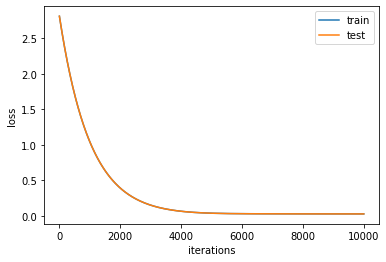

In [215]:
# Вызываем функцию
loss_and_iterations_hist(model)

# ВЫВОД: на графике признаки переобучения отсутствуют.

### Сохраним результаты модели и гиперпараметры в файл для дальнейшего сравнения моделей

In [216]:
model.get_params()

{'iterations': 10000,
 'learning_rate': 0.001,
 'depth': 6,
 'loss_function': <__main__.RMSLE at 0x7f57f0e984f0>,
 'random_seed': 42,
 'use_best_model': True,
 'verbose': 10,
 'train_dir': 'catboost_clf_modelbaseline_catboost_1_10000iter',
 'eval_metric': <__main__.RMSLE_val at 0x7f57f0dcf700>,
 'early_stopping_rounds': 50}

In [217]:
# Определяем функцию
def saving_model_metrics_and_hyperparameters(model, test_pool, model_number):
    """МЕТОД СОХРАНЯЕТ ПАРАМЕТРЫ ЗАПУЩЕННОЙ РАНЕЕ МОДЕЛИ И ЕЕ МЕТРИКИ"""
    """задаем директорию"""
    dataset_dir = "Model_metrics_diplom"

    """если ее нет, создаем директорию"""
    if not os.path.exists(dataset_dir):
        os.makedirs(dataset_dir)

    """рассчитываем метрики для модели"""
    test_metrics = model.eval_metrics(
        test_pool,
        metrics=['RMSE', 'MAE', 'R2'],
        ntree_start=model.best_iteration_ - 1,
        ntree_end=model.best_iteration_,
        eval_period=1,
        thread_count=-1)

    """добавляем рассчитанные метрики в словарь"""
    file_with_metrics = {}
    file_with_metrics[f'model{model_number}_metrics'] = []
    file_with_metrics[f'model{model_number}_metrics'].append(test_metrics)

#     """добавляем гиперпараметры модели в словарь"""
#     model_parameters = model.get_params()

#     file_with_metrics[f'model{model_number}_hyperparams'] = []
#     file_with_metrics[f'model{model_number}_hyperparams'].append(model_parameters)

    """добавляем метрики и гиперпараметры модели в файл jsonlines"""
    with open('Model_metrics_diplom/file_with_metrics.jsonlines', 'a', encoding='utf-8') as file:
        json.dump(file_with_metrics, file)
        file.write('\n')
        
    return file_with_metrics

In [218]:
#вызываем функцию
model_metrics_and_hyperparameters = saving_model_metrics_and_hyperparameters(model, test_pool, model_number)

In [219]:
model_metrics_and_hyperparameters

{'modelbaseline_catboost_1_10000iter_metrics': [{'RMSE': [0.47506834308979573],
   'MAE': [0.30058649453420627],
   'R2': [0.3728062289822309]}]}

### Сделаем предсказание модели на отложенной выборке (без разметки) и загрузим на kaggle

In [220]:
predictions = np.exp(model.predict(data_checked))
predictions

array([4758014.9425, 7650651.7597, 5216154.9156, ..., 4345116.9611,
       5226689.138 , 8237551.2471])

In [226]:
from sklearn.metrics import mean_squared_log_error
pred = np.exp(model.predict(data_checked))
rmsle = np.sqrt(mean_squared_log_error(data_checked, pred))

print('RMSLE: {:.3f}'.format(rmsle))

ValueError: y_true and y_pred have different number of output (332!=1)

1. Модель не предсказывает, если отличаются столбцы
2. Столбцы отличаются из из one hot encoding
3. Вопрос: как мне получить предсказания модели для проверочного датасета? Проверочный датасет нужно обрабатывать также, как и обучающий?

In [227]:
predict = np.exp(model.predict(data_checked))
submission = pd.DataFrame({'id': id_check, 'price_doc': predict})
submission.head()

,id,price_doc
0,30474,"4,758,014.94253"
1,30475,"7,650,651.75968"
2,30476,"5,216,154.91556"
3,30477,"5,144,135.74489"
4,30478,"4,862,503.93180"


In [ ]:
submission.to_csv('CatBoost_without_macro_50000iter.csv', index=False)

In [ ]:
#добавили макроэкономические показатели

In [ ]:
#увеличим количество итераций в 2 раза до 10000

In [ ]:
#увеличим количество итераций до 50000

# Применим алгоритм Random forest

In [228]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV

In [229]:
rf_regressor = RandomForestRegressor(n_estimators = 10)  
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)
rmse = metrics.root_mean_squared_error(y_test, y_pred)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.4995346974722149


In [230]:
predict_rf = np.exp(rf_regressor.predict(data_checked))
submission_fr = pd.DataFrame({'id': id_check, 'price_doc': predict_rf})
submission.head()

,id,price_doc
0,30474,"4,758,014.94253"
1,30475,"7,650,651.75968"
2,30476,"5,216,154.91556"
3,30477,"5,144,135.74489"
4,30478,"4,862,503.93180"


In [231]:
submission.to_csv('CatBoost_without_macro_rf.csv', index=False)

# Попробуем подобрать параметры сеткой для random forest

In [ ]:
# инициализируем модель
model_cv = RandomForestRegressor(random_state=42)

# Define the parameter grid for Grid Search
param_grid = {
    "n_estimators"      : [10, 50,100,150],
     "max_features"      : ["auto", "sqrt", "log2"],
     "min_samples_split" : [2,4,8],
     "bootstrap": [True, False],
     "max_depth" : [5,20]
    }
 
grid_search = GridSearchCV(model_cv, param_grid, n_jobs=-1, cv=5)


grid_search.fit(X_train, y_train)
 
# Вывод наилучших гиперпараметров и оценки
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)
print("Best model:", grid_search.best_estimator_) 

In [ ]:
# Best Hyperparameters: {'bootstrap': True
# , 'max_depth': 20
#     , 'max_features': 'sqrt'
#         , 'min_samples_split': 8
#             , 'n_estimators': 150}
# Best Cross-Validation Score: 0.3815965410675243

In [ ]:
# получили лучшую модель
print("Best model:", grid_search.best_estimator_) 

In [ ]:
# Best model: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_split=8,
#                       n_estimators=150, random_state=42)

In [ ]:
# сделаем предскание подобранной через grid_search модели
predict_rf_grid_search = np.exp(grid_search.best_estimator_.predict(data_checked))
submission_fr_grid_search = pd.DataFrame({'id': id_check, 'price_doc': predict_rf_grid_search})
submission_fr_grid_search.head()

In [ ]:
submission_fr_grid_search.to_csv('CatBoost_without_macro_rf_grid.csv', index=False)

# Еще раз подберем параметры

In [ ]:
# инициализируем модель
model_cv_2 = RandomForestRegressor(random_state=42)

# Define the parameter grid for Grid Search
param_grid_2 = {
    "n_estimators"      : [150, 300, 500],
     "max_features"      : ["sqrt"],
     "min_samples_split" : [8,10,15],
     "bootstrap": [True],
     "max_depth" : [20,30, 50]
    }
 
grid_search_2 = GridSearchCV(model_cv_2, param_grid_2, n_jobs=-1, cv=5)


grid_search_2.fit(X_train, y_train)
 
# Вывод наилучших гиперпараметров и оценки
print("Best Hyperparameters:", grid_search_2.best_params_)
print("Best Cross-Validation Score:", grid_search_2.best_score_)
print("Best model:", grid_search_2.best_estimator_) 

In [ ]:
# сделаем предскание подобранной через grid_search модели
predict_rf_grid_search2 = np.exp(grid_search_2.best_estimator_.predict(data_checked))
submission_fr_grid_search2 = pd.DataFrame({'id': id_check, 'price_doc': predict_rf_grid_search2})
submission_fr_grid_search2.head()

In [ ]:
submission_fr_grid_search2.to_csv('CatBoost_without_macro_rf_grid2.csv', index=False)

# Попробуем LightGBM

In [ ]:
#  создаем датасет для LightGBM
train_data_lgb = lgb.Dataset(X_train, label=y_train) 
test_data_lgb = lgb.Dataset(X_test, label=y_test, reference=train_data_lgb) 

In [ ]:
lgb_params = { 
    'task': 'train',
    'objective': 'regression', 
    'metric': 'rmse', 
    'boosting_type': 'gbdt', 
    'num_leaves': 31, 
    'learning_rate': 0.05, 
    'feature_fraction': 0.9, 
    'force_col_wise': True,
    'verbose': -1,
    'early_stopping_rounds': 30
} 

In [ ]:
# обучение модели, загрузка данных
model_lgb = lgb.train(lgb_params, train_set=train_data_lgb, valid_sets=test_data_lgb)

In [ ]:
y_pred = model_lgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(0.5)
print("MSE: %.2f"% mse)
print("RMSE: %.2f"% rmse)

In [ ]:
# сделаем предскание подобранной через grid_search модели
predict_lgbm = np.exp(model_lgb.predict(data_checked))
submission_lgbm = pd.DataFrame({'id': id_check, 'price_doc': predict_lgbm})
submission_lgbm.head()

In [ ]:
submission_lgbm.to_csv('LGBM_without_macro.csv', index=False)

In [ ]:
# метрика схожа с catboost

# Cделаем blending

In [92]:
from math import sqrt
from numpy import hstack
from numpy import vstack
from numpy import asarray
# from sklearn.datasets.samples_generator import make_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [93]:
cb = CatBoostRegressor(early_stopping_rounds=50,
        random_seed=42)

In [94]:
# from scipy.sparse import hstack

In [95]:
# get a list of base models
def get_models():
    models = list()
    models.append(('cb', CatBoostRegressor()))
    models.append(('lgbm', LGBMRegressor()))
    models.append(('rf', RandomForestRegressor()))
    return models

In [96]:
models = get_models()

In [97]:
models

[('cb', <catboost.core.CatBoostRegressor at 0x7f57cc348b80>),
 ('lgbm', LGBMRegressor()),
 ('rf', RandomForestRegressor())]

In [106]:
def fit_ensemble(models, X_train, X_val, y_train, y_val):
    # fit all models on the training set and predict on hold out set
    meta_X = list()
    meta_y = list()
    for _, model in models:
        # fit in training set
        model.fit(X_train, y_train)
        # predict on hold out set
        yhat = model.predict(X_val)
        print(yhat)
        # reshape predictions into a matrix with one column
        # store predictions as input for blending
        yhat = yhat.reshape(len(yhat), 1)
        # print(yhat)
        meta_X = np.append(meta_X, yhat)
        # print(meta_X)
        meta_y = np.append(meta_y, y_val)
        # create 2d array from predictions, each set is an input feature
    meta_X = hstack(meta_X)
    # define blending model
    blender = CatBoostRegressor()
    # fit on predictions from base models
    blender.fit(meta_X, meta_y)
    return blender

In [107]:
blender = fit_ensemble(models, X_train, X_val, y_train, y_val)

Learning rate set to 0.0591
0:	learn: 0.5935815	total: 22ms	remaining: 22s
1:	learn: 0.5843629	total: 27.5ms	remaining: 13.7s
2:	learn: 0.5766036	total: 33.3ms	remaining: 11.1s
3:	learn: 0.5691682	total: 39.2ms	remaining: 9.77s
4:	learn: 0.5624102	total: 45.2ms	remaining: 8.99s
5:	learn: 0.5564594	total: 50.9ms	remaining: 8.44s
6:	learn: 0.5506072	total: 56.5ms	remaining: 8.02s
7:	learn: 0.5452100	total: 62.5ms	remaining: 7.75s
8:	learn: 0.5401373	total: 68.1ms	remaining: 7.5s
9:	learn: 0.5353059	total: 73.8ms	remaining: 7.3s
10:	learn: 0.5309234	total: 79.5ms	remaining: 7.14s
11:	learn: 0.5266989	total: 85.3ms	remaining: 7.02s
12:	learn: 0.5229468	total: 91.5ms	remaining: 6.94s
13:	learn: 0.5194906	total: 97.3ms	remaining: 6.85s
14:	learn: 0.5167034	total: 103ms	remaining: 6.76s
15:	learn: 0.5138897	total: 109ms	remaining: 6.69s
16:	learn: 0.5115007	total: 115ms	remaining: 6.62s
17:	learn: 0.5090988	total: 120ms	remaining: 6.57s
18:	learn: 0.5065556	total: 126ms	remaining: 6.51s
19:	l

190:	learn: 0.4371372	total: 1.17s	remaining: 4.97s
191:	learn: 0.4369739	total: 1.18s	remaining: 4.96s
192:	learn: 0.4367780	total: 1.19s	remaining: 4.96s
193:	learn: 0.4364806	total: 1.2s	remaining: 4.99s
194:	learn: 0.4363387	total: 1.22s	remaining: 5.03s
195:	learn: 0.4362139	total: 1.23s	remaining: 5.03s
196:	learn: 0.4359001	total: 1.24s	remaining: 5.03s
197:	learn: 0.4357002	total: 1.24s	remaining: 5.03s
198:	learn: 0.4356393	total: 1.25s	remaining: 5.04s
199:	learn: 0.4353826	total: 1.26s	remaining: 5.04s
200:	learn: 0.4351785	total: 1.27s	remaining: 5.03s
201:	learn: 0.4351516	total: 1.27s	remaining: 5.03s
202:	learn: 0.4350061	total: 1.28s	remaining: 5.02s
203:	learn: 0.4348399	total: 1.28s	remaining: 5.01s
204:	learn: 0.4346688	total: 1.29s	remaining: 5s
205:	learn: 0.4343244	total: 1.29s	remaining: 4.99s
206:	learn: 0.4341199	total: 1.3s	remaining: 4.99s
207:	learn: 0.4340456	total: 1.31s	remaining: 4.98s
208:	learn: 0.4337432	total: 1.31s	remaining: 4.97s
209:	learn: 0.433

350:	learn: 0.4066360	total: 2.16s	remaining: 4s
351:	learn: 0.4063912	total: 2.17s	remaining: 3.99s
352:	learn: 0.4063172	total: 2.17s	remaining: 3.99s
353:	learn: 0.4060266	total: 2.18s	remaining: 3.98s
354:	learn: 0.4058150	total: 2.19s	remaining: 3.98s
355:	learn: 0.4056892	total: 2.2s	remaining: 3.97s
356:	learn: 0.4056266	total: 2.2s	remaining: 3.97s
357:	learn: 0.4055029	total: 2.21s	remaining: 3.96s
358:	learn: 0.4052869	total: 2.21s	remaining: 3.96s
359:	learn: 0.4052370	total: 2.22s	remaining: 3.95s
360:	learn: 0.4050949	total: 2.23s	remaining: 3.94s
361:	learn: 0.4049384	total: 2.23s	remaining: 3.94s
362:	learn: 0.4047820	total: 2.24s	remaining: 3.93s
363:	learn: 0.4044371	total: 2.24s	remaining: 3.92s
364:	learn: 0.4041480	total: 2.25s	remaining: 3.92s
365:	learn: 0.4039742	total: 2.26s	remaining: 3.91s
366:	learn: 0.4039585	total: 2.26s	remaining: 3.9s
367:	learn: 0.4036990	total: 2.27s	remaining: 3.9s
368:	learn: 0.4035293	total: 2.27s	remaining: 3.89s
369:	learn: 0.40323

537:	learn: 0.3762417	total: 3.36s	remaining: 2.89s
538:	learn: 0.3760712	total: 3.37s	remaining: 2.88s
539:	learn: 0.3759943	total: 3.38s	remaining: 2.88s
540:	learn: 0.3758433	total: 3.38s	remaining: 2.87s
541:	learn: 0.3758239	total: 3.39s	remaining: 2.86s
542:	learn: 0.3757202	total: 3.4s	remaining: 2.86s
543:	learn: 0.3755735	total: 3.4s	remaining: 2.85s
544:	learn: 0.3754343	total: 3.41s	remaining: 2.85s
545:	learn: 0.3752792	total: 3.42s	remaining: 2.84s
546:	learn: 0.3751959	total: 3.42s	remaining: 2.83s
547:	learn: 0.3749939	total: 3.43s	remaining: 2.83s
548:	learn: 0.3748662	total: 3.43s	remaining: 2.82s
549:	learn: 0.3747054	total: 3.44s	remaining: 2.81s
550:	learn: 0.3745647	total: 3.44s	remaining: 2.81s
551:	learn: 0.3744482	total: 3.45s	remaining: 2.8s
552:	learn: 0.3743044	total: 3.46s	remaining: 2.79s
553:	learn: 0.3742802	total: 3.46s	remaining: 2.79s
554:	learn: 0.3740170	total: 3.47s	remaining: 2.78s
555:	learn: 0.3738552	total: 3.47s	remaining: 2.77s
556:	learn: 0.3

699:	learn: 0.3536659	total: 4.36s	remaining: 1.87s
700:	learn: 0.3534721	total: 4.36s	remaining: 1.86s
701:	learn: 0.3533517	total: 4.37s	remaining: 1.85s
702:	learn: 0.3533017	total: 4.38s	remaining: 1.85s
703:	learn: 0.3531790	total: 4.38s	remaining: 1.84s
704:	learn: 0.3530027	total: 4.39s	remaining: 1.84s
705:	learn: 0.3528294	total: 4.4s	remaining: 1.83s
706:	learn: 0.3527239	total: 4.4s	remaining: 1.82s
707:	learn: 0.3526784	total: 4.41s	remaining: 1.82s
708:	learn: 0.3525500	total: 4.41s	remaining: 1.81s
709:	learn: 0.3523205	total: 4.42s	remaining: 1.8s
710:	learn: 0.3522326	total: 4.43s	remaining: 1.8s
711:	learn: 0.3521713	total: 4.43s	remaining: 1.79s
712:	learn: 0.3520091	total: 4.44s	remaining: 1.79s
713:	learn: 0.3518880	total: 4.44s	remaining: 1.78s
714:	learn: 0.3518047	total: 4.45s	remaining: 1.77s
715:	learn: 0.3516389	total: 4.46s	remaining: 1.77s
716:	learn: 0.3515074	total: 4.46s	remaining: 1.76s
717:	learn: 0.3513503	total: 4.47s	remaining: 1.75s
718:	learn: 0.35

887:	learn: 0.3303489	total: 5.55s	remaining: 701ms
888:	learn: 0.3302841	total: 5.56s	remaining: 695ms
889:	learn: 0.3301756	total: 5.57s	remaining: 688ms
890:	learn: 0.3300497	total: 5.58s	remaining: 682ms
891:	learn: 0.3299418	total: 5.58s	remaining: 676ms
892:	learn: 0.3298084	total: 5.59s	remaining: 670ms
893:	learn: 0.3296826	total: 5.59s	remaining: 663ms
894:	learn: 0.3295038	total: 5.6s	remaining: 657ms
895:	learn: 0.3294549	total: 5.61s	remaining: 651ms
896:	learn: 0.3293143	total: 5.61s	remaining: 645ms
897:	learn: 0.3291104	total: 5.62s	remaining: 638ms
898:	learn: 0.3290001	total: 5.63s	remaining: 632ms
899:	learn: 0.3289565	total: 5.63s	remaining: 626ms
900:	learn: 0.3288578	total: 5.64s	remaining: 620ms
901:	learn: 0.3287113	total: 5.64s	remaining: 613ms
902:	learn: 0.3284851	total: 5.65s	remaining: 607ms
903:	learn: 0.3283523	total: 5.66s	remaining: 601ms
904:	learn: 0.3282812	total: 5.66s	remaining: 595ms
905:	learn: 0.3281785	total: 5.67s	remaining: 588ms
906:	learn: 0

166:	learn: 0.4929986	total: 171ms	remaining: 851ms
167:	learn: 0.4929869	total: 172ms	remaining: 852ms
168:	learn: 0.4929714	total: 174ms	remaining: 853ms
169:	learn: 0.4929687	total: 175ms	remaining: 854ms
170:	learn: 0.4929615	total: 177ms	remaining: 856ms
171:	learn: 0.4929545	total: 178ms	remaining: 857ms
172:	learn: 0.4929443	total: 180ms	remaining: 859ms
173:	learn: 0.4929397	total: 181ms	remaining: 859ms
174:	learn: 0.4929335	total: 182ms	remaining: 860ms
175:	learn: 0.4929230	total: 184ms	remaining: 862ms
176:	learn: 0.4929053	total: 186ms	remaining: 863ms
177:	learn: 0.4928972	total: 187ms	remaining: 865ms
178:	learn: 0.4928893	total: 189ms	remaining: 866ms
179:	learn: 0.4928848	total: 190ms	remaining: 867ms
180:	learn: 0.4928719	total: 192ms	remaining: 868ms
181:	learn: 0.4928666	total: 193ms	remaining: 868ms
182:	learn: 0.4928546	total: 194ms	remaining: 868ms
183:	learn: 0.4928444	total: 195ms	remaining: 867ms
184:	learn: 0.4928319	total: 197ms	remaining: 866ms
185:	learn: 

439:	learn: 0.4911393	total: 544ms	remaining: 692ms
440:	learn: 0.4911384	total: 545ms	remaining: 691ms
441:	learn: 0.4911348	total: 547ms	remaining: 690ms
442:	learn: 0.4911312	total: 548ms	remaining: 689ms
443:	learn: 0.4911285	total: 549ms	remaining: 688ms
444:	learn: 0.4911277	total: 551ms	remaining: 687ms
445:	learn: 0.4911271	total: 552ms	remaining: 685ms
446:	learn: 0.4911266	total: 553ms	remaining: 684ms
447:	learn: 0.4911222	total: 554ms	remaining: 683ms
448:	learn: 0.4911201	total: 556ms	remaining: 682ms
449:	learn: 0.4911162	total: 557ms	remaining: 681ms
450:	learn: 0.4911095	total: 559ms	remaining: 680ms
451:	learn: 0.4911067	total: 560ms	remaining: 679ms
452:	learn: 0.4911029	total: 562ms	remaining: 678ms
453:	learn: 0.4911001	total: 563ms	remaining: 677ms
454:	learn: 0.4910984	total: 565ms	remaining: 676ms
455:	learn: 0.4910952	total: 566ms	remaining: 675ms
456:	learn: 0.4910931	total: 567ms	remaining: 674ms
457:	learn: 0.4910869	total: 569ms	remaining: 673ms
458:	learn: 

709:	learn: 0.4906135	total: 923ms	remaining: 377ms
710:	learn: 0.4906121	total: 925ms	remaining: 376ms
711:	learn: 0.4906107	total: 926ms	remaining: 375ms
712:	learn: 0.4906102	total: 928ms	remaining: 374ms
713:	learn: 0.4906093	total: 930ms	remaining: 372ms
714:	learn: 0.4906089	total: 931ms	remaining: 371ms
715:	learn: 0.4906080	total: 933ms	remaining: 370ms
716:	learn: 0.4906076	total: 935ms	remaining: 369ms
717:	learn: 0.4906068	total: 937ms	remaining: 368ms
718:	learn: 0.4906059	total: 938ms	remaining: 367ms
719:	learn: 0.4906045	total: 940ms	remaining: 366ms
720:	learn: 0.4906029	total: 942ms	remaining: 364ms
721:	learn: 0.4906012	total: 943ms	remaining: 363ms
722:	learn: 0.4906005	total: 945ms	remaining: 362ms
723:	learn: 0.4905998	total: 947ms	remaining: 361ms
724:	learn: 0.4905986	total: 948ms	remaining: 360ms
725:	learn: 0.4905983	total: 950ms	remaining: 358ms
726:	learn: 0.4905980	total: 951ms	remaining: 357ms
727:	learn: 0.4905978	total: 952ms	remaining: 356ms
728:	learn: 

963:	learn: 0.4904370	total: 1.3s	remaining: 48.6ms
964:	learn: 0.4904365	total: 1.3s	remaining: 47.2ms
965:	learn: 0.4904363	total: 1.3s	remaining: 45.9ms
966:	learn: 0.4904358	total: 1.31s	remaining: 44.6ms
967:	learn: 0.4904350	total: 1.31s	remaining: 43.2ms
968:	learn: 0.4904345	total: 1.31s	remaining: 41.9ms
969:	learn: 0.4904344	total: 1.31s	remaining: 40.5ms
970:	learn: 0.4904339	total: 1.31s	remaining: 39.2ms
971:	learn: 0.4904333	total: 1.31s	remaining: 37.9ms
972:	learn: 0.4904325	total: 1.32s	remaining: 36.5ms
973:	learn: 0.4904322	total: 1.32s	remaining: 35.2ms
974:	learn: 0.4904320	total: 1.32s	remaining: 33.8ms
975:	learn: 0.4904318	total: 1.32s	remaining: 32.5ms
976:	learn: 0.4904317	total: 1.32s	remaining: 31.1ms
977:	learn: 0.4904313	total: 1.32s	remaining: 29.8ms
978:	learn: 0.4904307	total: 1.32s	remaining: 28.4ms
979:	learn: 0.4904301	total: 1.32s	remaining: 27.1ms
980:	learn: 0.4904298	total: 1.33s	remaining: 25.7ms
981:	learn: 0.4904293	total: 1.33s	remaining: 24.

In [136]:
# make a prediction with the blending ensemble
def predict_ensemble(models, blender, X_test):
    # make predictions with base models
    meta_X = pd.DataFrame()
    for name, model in models:
        # predict with base model
        print(X_test)
        yhat = model.predict(X_test)
        df_yhat = pd.DataFrame(yhat)
        # reshape predictions into a matrix with one column
        # yhat = yhat.reshape(len(yhat), 1)
        # store prediction
        # meta_X.append(yhat)
        meta_X = pd.concat([meta_X, df_yhat], axis=1)
        print(meta_X)
        # create 2d array from predictions, each set is an input feature
    # meta_X = hstack(meta_X)
    # print("meta_X", meta_X)
    # predict
    return blender.predict(meta_X)

In [137]:
predict_ensemble(models, blender, X_test)

       full_sq  life_sq    floor  num_room   state           area_m  \
30379       32 18.00000  3.00000   1.00000 2.00000 10,053,051.74000   
27256       77 34.40327  2.00000   3.00000 1.00000 25,536,296.81000   
23193       37 18.00000  8.00000   1.00000 2.00000 25,536,296.81000   
18055       38 20.00000 11.00000   1.00000 2.00000 10,842,309.74000   
5623        34 34.00000 11.00000   2.00000 2.00000 52,995,275.39000   
...        ...      ...      ...       ...     ...              ...   
7215        38 35.00000 14.00000   2.00000 2.00000 11,324,091.93000   
21915       52 30.00000  7.00000   2.00000 2.00000  6,050,064.56600   
24779       32 18.00000  9.00000   1.00000 2.00000  7,462,269.56300   
28974       30 18.00000  5.00000   1.00000 3.00000  8,841,267.45400   
13699       56 41.00000  3.00000   3.00000 2.00000  4,048,456.78200   

       raion_popul  children_preschool  preschool_education_centers_raion  \
30379       175518                9753                                

             0        0        0
0     15.62032 15.57951 15.51743
1     15.97114 15.87487 15.89665
2     15.22341 15.25579 15.26332
3     15.20971 15.08290 14.79701
4     14.96771 15.03371 14.93891
...        ...      ...      ...
15230 15.33497 15.15841 15.09802
15231 15.97139 15.97473 15.50649
15232 15.47481 15.39581 15.47018
15233 15.36713 15.09547 15.40352
15234 15.86044 16.03728 15.76990

[15235 rows x 3 columns]


CatBoostError: catboost/libs/data/features_layout.cpp:124: All feature names should be different, but '0' used more than once.

In [102]:
X_data.shape

(30470, 332)

In [118]:
# # define dataset
# X_data, y_data = get_dataset()
# split dataset into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X_data, y_data, test_size=0.5, random_state=42)
# split training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.33, random_state=42)
# summarize data split
print('Train: %s, Val: %s, Test: %s' % (X_train.shape, X_val.shape, X_test.shape))
# create the base models
print('Train: %s, Val: %s, Test: %s' % (y_train.shape, y_val.shape, y_test.shape))
models = get_models()
# train the blending ensemble
blender = fit_ensemble(models, X_train, X_val, y_train, y_val)
# make predictions on test set
yhat = predict_ensemble(models, blender, X_test)
# evaluate predictions
score = mean_absolute_error(y_test, yhat)
print('Blending MAE: %.3f' % score)

Train: (10207, 332), Val: (5028, 332), Test: (15235, 332)
Train: (10207,), Val: (5028,), Test: (15235,)
Learning rate set to 0.0591
0:	learn: 0.5935815	total: 20.3ms	remaining: 20.3s
1:	learn: 0.5843629	total: 25.9ms	remaining: 12.9s
2:	learn: 0.5766036	total: 31.5ms	remaining: 10.5s
3:	learn: 0.5691682	total: 37.6ms	remaining: 9.36s
4:	learn: 0.5624102	total: 44ms	remaining: 8.75s
5:	learn: 0.5564594	total: 49.7ms	remaining: 8.23s
6:	learn: 0.5506072	total: 55.2ms	remaining: 7.83s
7:	learn: 0.5452100	total: 61.2ms	remaining: 7.59s
8:	learn: 0.5401373	total: 67.1ms	remaining: 7.38s
9:	learn: 0.5353059	total: 72.8ms	remaining: 7.2s
10:	learn: 0.5309234	total: 78.5ms	remaining: 7.06s
11:	learn: 0.5266989	total: 84.5ms	remaining: 6.96s
12:	learn: 0.5229468	total: 92.6ms	remaining: 7.03s
13:	learn: 0.5194906	total: 102ms	remaining: 7.16s
14:	learn: 0.5167034	total: 111ms	remaining: 7.27s
15:	learn: 0.5138897	total: 125ms	remaining: 7.71s
16:	learn: 0.5115007	total: 133ms	remaining: 7.68s
1

161:	learn: 0.4430611	total: 1.15s	remaining: 5.93s
162:	learn: 0.4428193	total: 1.15s	remaining: 5.93s
163:	learn: 0.4426075	total: 1.16s	remaining: 5.92s
164:	learn: 0.4424027	total: 1.17s	remaining: 5.92s
165:	learn: 0.4421534	total: 1.18s	remaining: 5.91s
166:	learn: 0.4419298	total: 1.18s	remaining: 5.9s
167:	learn: 0.4416919	total: 1.19s	remaining: 5.89s
168:	learn: 0.4415843	total: 1.2s	remaining: 5.88s
169:	learn: 0.4412292	total: 1.2s	remaining: 5.88s
170:	learn: 0.4410281	total: 1.21s	remaining: 5.88s
171:	learn: 0.4408054	total: 1.22s	remaining: 5.87s
172:	learn: 0.4406334	total: 1.22s	remaining: 5.85s
173:	learn: 0.4403340	total: 1.23s	remaining: 5.85s
174:	learn: 0.4401569	total: 1.24s	remaining: 5.84s
175:	learn: 0.4399812	total: 1.25s	remaining: 5.83s
176:	learn: 0.4398135	total: 1.25s	remaining: 5.82s
177:	learn: 0.4396184	total: 1.26s	remaining: 5.81s
178:	learn: 0.4393446	total: 1.26s	remaining: 5.8s
179:	learn: 0.4391560	total: 1.27s	remaining: 5.79s
180:	learn: 0.43

336:	learn: 0.4093550	total: 2.34s	remaining: 4.61s
337:	learn: 0.4091804	total: 2.35s	remaining: 4.6s
338:	learn: 0.4088463	total: 2.35s	remaining: 4.59s
339:	learn: 0.4085953	total: 2.36s	remaining: 4.58s
340:	learn: 0.4082975	total: 2.37s	remaining: 4.58s
341:	learn: 0.4081092	total: 2.37s	remaining: 4.57s
342:	learn: 0.4079300	total: 2.38s	remaining: 4.56s
343:	learn: 0.4077996	total: 2.38s	remaining: 4.55s
344:	learn: 0.4075315	total: 2.39s	remaining: 4.54s
345:	learn: 0.4074189	total: 2.4s	remaining: 4.53s
346:	learn: 0.4072676	total: 2.4s	remaining: 4.53s
347:	learn: 0.4071456	total: 2.41s	remaining: 4.52s
348:	learn: 0.4070520	total: 2.42s	remaining: 4.51s
349:	learn: 0.4068671	total: 2.42s	remaining: 4.5s
350:	learn: 0.4066360	total: 2.43s	remaining: 4.49s
351:	learn: 0.4063912	total: 2.43s	remaining: 4.48s
352:	learn: 0.4063172	total: 2.44s	remaining: 4.47s
353:	learn: 0.4060266	total: 2.45s	remaining: 4.46s
354:	learn: 0.4058150	total: 2.45s	remaining: 4.46s
355:	learn: 0.40

500:	learn: 0.3815568	total: 3.33s	remaining: 3.32s
501:	learn: 0.3813451	total: 3.34s	remaining: 3.31s
502:	learn: 0.3812960	total: 3.35s	remaining: 3.31s
503:	learn: 0.3810805	total: 3.35s	remaining: 3.3s
504:	learn: 0.3808703	total: 3.36s	remaining: 3.29s
505:	learn: 0.3807938	total: 3.37s	remaining: 3.29s
506:	learn: 0.3805815	total: 3.37s	remaining: 3.28s
507:	learn: 0.3804290	total: 3.38s	remaining: 3.27s
508:	learn: 0.3803355	total: 3.38s	remaining: 3.26s
509:	learn: 0.3801118	total: 3.39s	remaining: 3.26s
510:	learn: 0.3799344	total: 3.4s	remaining: 3.25s
511:	learn: 0.3798679	total: 3.4s	remaining: 3.24s
512:	learn: 0.3797853	total: 3.41s	remaining: 3.23s
513:	learn: 0.3795100	total: 3.41s	remaining: 3.23s
514:	learn: 0.3794009	total: 3.42s	remaining: 3.22s
515:	learn: 0.3793788	total: 3.42s	remaining: 3.21s
516:	learn: 0.3792997	total: 3.43s	remaining: 3.21s
517:	learn: 0.3791876	total: 3.44s	remaining: 3.2s
518:	learn: 0.3791664	total: 3.44s	remaining: 3.19s
519:	learn: 0.37

664:	learn: 0.3581659	total: 4.33s	remaining: 2.18s
665:	learn: 0.3581128	total: 4.33s	remaining: 2.17s
666:	learn: 0.3580122	total: 4.34s	remaining: 2.17s
667:	learn: 0.3578943	total: 4.35s	remaining: 2.16s
668:	learn: 0.3577842	total: 4.35s	remaining: 2.15s
669:	learn: 0.3576479	total: 4.36s	remaining: 2.15s
670:	learn: 0.3576405	total: 4.36s	remaining: 2.14s
671:	learn: 0.3575348	total: 4.37s	remaining: 2.13s
672:	learn: 0.3573811	total: 4.38s	remaining: 2.13s
673:	learn: 0.3572852	total: 4.38s	remaining: 2.12s
674:	learn: 0.3572089	total: 4.39s	remaining: 2.11s
675:	learn: 0.3571152	total: 4.39s	remaining: 2.1s
676:	learn: 0.3570012	total: 4.4s	remaining: 2.1s
677:	learn: 0.3568109	total: 4.41s	remaining: 2.09s
678:	learn: 0.3567229	total: 4.41s	remaining: 2.08s
679:	learn: 0.3566229	total: 4.42s	remaining: 2.08s
680:	learn: 0.3563927	total: 4.42s	remaining: 2.07s
681:	learn: 0.3562499	total: 4.43s	remaining: 2.06s
682:	learn: 0.3561256	total: 4.44s	remaining: 2.06s
683:	learn: 0.3

825:	learn: 0.3372859	total: 5.32s	remaining: 1.12s
826:	learn: 0.3371529	total: 5.33s	remaining: 1.11s
827:	learn: 0.3370422	total: 5.34s	remaining: 1.11s
828:	learn: 0.3368654	total: 5.34s	remaining: 1.1s
829:	learn: 0.3368216	total: 5.35s	remaining: 1.1s
830:	learn: 0.3366740	total: 5.36s	remaining: 1.09s
831:	learn: 0.3366261	total: 5.37s	remaining: 1.08s
832:	learn: 0.3365124	total: 5.37s	remaining: 1.08s
833:	learn: 0.3363441	total: 5.38s	remaining: 1.07s
834:	learn: 0.3362263	total: 5.39s	remaining: 1.06s
835:	learn: 0.3361150	total: 5.39s	remaining: 1.06s
836:	learn: 0.3360517	total: 5.4s	remaining: 1.05s
837:	learn: 0.3359453	total: 5.41s	remaining: 1.04s
838:	learn: 0.3358540	total: 5.42s	remaining: 1.04s
839:	learn: 0.3356531	total: 5.42s	remaining: 1.03s
840:	learn: 0.3355849	total: 5.43s	remaining: 1.03s
841:	learn: 0.3355141	total: 5.43s	remaining: 1.02s
842:	learn: 0.3354263	total: 5.44s	remaining: 1.01s
843:	learn: 0.3353116	total: 5.45s	remaining: 1.01s
844:	learn: 0.3

985:	learn: 0.3191270	total: 6.31s	remaining: 89.7ms
986:	learn: 0.3190120	total: 6.32s	remaining: 83.3ms
987:	learn: 0.3189088	total: 6.33s	remaining: 76.8ms
988:	learn: 0.3187955	total: 6.33s	remaining: 70.4ms
989:	learn: 0.3187099	total: 6.34s	remaining: 64ms
990:	learn: 0.3186924	total: 6.34s	remaining: 57.6ms
991:	learn: 0.3185356	total: 6.35s	remaining: 51.2ms
992:	learn: 0.3184189	total: 6.36s	remaining: 44.8ms
993:	learn: 0.3182523	total: 6.36s	remaining: 38.4ms
994:	learn: 0.3180433	total: 6.37s	remaining: 32ms
995:	learn: 0.3178848	total: 6.38s	remaining: 25.6ms
996:	learn: 0.3177892	total: 6.38s	remaining: 19.2ms
997:	learn: 0.3175641	total: 6.39s	remaining: 12.8ms
998:	learn: 0.3175208	total: 6.39s	remaining: 6.4ms
999:	learn: 0.3174522	total: 6.4s	remaining: 0us
[15.4086 15.7211 15.0997 ... 15.4095 15.1218 15.1416]
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

281:	learn: 0.4921251	total: 338ms	remaining: 860ms
282:	learn: 0.4921215	total: 340ms	remaining: 860ms
283:	learn: 0.4921166	total: 341ms	remaining: 860ms
284:	learn: 0.4921084	total: 343ms	remaining: 860ms
285:	learn: 0.4921068	total: 344ms	remaining: 859ms
286:	learn: 0.4920986	total: 346ms	remaining: 859ms
287:	learn: 0.4920949	total: 347ms	remaining: 859ms
288:	learn: 0.4920900	total: 349ms	remaining: 858ms
289:	learn: 0.4920817	total: 350ms	remaining: 857ms
290:	learn: 0.4920779	total: 352ms	remaining: 856ms
291:	learn: 0.4920763	total: 353ms	remaining: 855ms
292:	learn: 0.4920673	total: 354ms	remaining: 854ms
293:	learn: 0.4920660	total: 355ms	remaining: 853ms
294:	learn: 0.4920635	total: 356ms	remaining: 852ms
295:	learn: 0.4920584	total: 358ms	remaining: 851ms
296:	learn: 0.4920458	total: 359ms	remaining: 850ms
297:	learn: 0.4920427	total: 360ms	remaining: 849ms
298:	learn: 0.4920339	total: 362ms	remaining: 849ms
299:	learn: 0.4920268	total: 363ms	remaining: 848ms
300:	learn: 

551:	learn: 0.4909290	total: 716ms	remaining: 581ms
552:	learn: 0.4909246	total: 718ms	remaining: 580ms
553:	learn: 0.4909236	total: 720ms	remaining: 580ms
554:	learn: 0.4909217	total: 722ms	remaining: 579ms
555:	learn: 0.4909188	total: 723ms	remaining: 577ms
556:	learn: 0.4909172	total: 725ms	remaining: 576ms
557:	learn: 0.4909150	total: 726ms	remaining: 575ms
558:	learn: 0.4909122	total: 728ms	remaining: 574ms
559:	learn: 0.4909106	total: 729ms	remaining: 573ms
560:	learn: 0.4909080	total: 730ms	remaining: 572ms
561:	learn: 0.4909039	total: 732ms	remaining: 570ms
562:	learn: 0.4909026	total: 733ms	remaining: 569ms
563:	learn: 0.4909001	total: 735ms	remaining: 568ms
564:	learn: 0.4908967	total: 737ms	remaining: 567ms
565:	learn: 0.4908963	total: 739ms	remaining: 566ms
566:	learn: 0.4908947	total: 740ms	remaining: 565ms
567:	learn: 0.4908918	total: 742ms	remaining: 564ms
568:	learn: 0.4908912	total: 743ms	remaining: 563ms
569:	learn: 0.4908898	total: 745ms	remaining: 562ms
570:	learn: 

818:	learn: 0.4905335	total: 1.1s	remaining: 242ms
819:	learn: 0.4905332	total: 1.1s	remaining: 241ms
820:	learn: 0.4905331	total: 1.1s	remaining: 240ms
821:	learn: 0.4905326	total: 1.1s	remaining: 238ms
822:	learn: 0.4905325	total: 1.1s	remaining: 237ms
823:	learn: 0.4905317	total: 1.1s	remaining: 236ms
824:	learn: 0.4905306	total: 1.11s	remaining: 235ms
825:	learn: 0.4905301	total: 1.11s	remaining: 233ms
826:	learn: 0.4905295	total: 1.11s	remaining: 232ms
827:	learn: 0.4905291	total: 1.11s	remaining: 231ms
828:	learn: 0.4905285	total: 1.11s	remaining: 229ms
829:	learn: 0.4905278	total: 1.11s	remaining: 228ms
830:	learn: 0.4905260	total: 1.11s	remaining: 227ms
831:	learn: 0.4905251	total: 1.12s	remaining: 225ms
832:	learn: 0.4905245	total: 1.12s	remaining: 224ms
833:	learn: 0.4905242	total: 1.12s	remaining: 223ms
834:	learn: 0.4905237	total: 1.12s	remaining: 221ms
835:	learn: 0.4905233	total: 1.12s	remaining: 220ms
836:	learn: 0.4905224	total: 1.12s	remaining: 219ms
837:	learn: 0.4905

NameError: name 'mean_absolute_error' is not defined

In [119]:
yhat = predict_ensemble(models, blender, data_checked)
# сделаем предскание подобранной через grid_search модели
predict_blending_models = np.exp(blender.predict(data_checked))
submission_blending_models = pd.DataFrame({'id': id_check, 'price_doc': predict_blending_models})
submission_blending_models.head(15)

,id,price_doc
0,30474,"36,957,050.71381"
1,30475,"36,957,050.71381"
2,30476,"36,957,050.71381"
3,30477,"36,957,050.71381"
4,30478,"36,957,050.71381"
5,30479,"36,957,050.71381"
6,30480,"36,957,050.71381"
7,30481,"36,957,050.71381"
8,30482,"36,957,050.71381"
9,30483,"36,957,050.71381"


In [ ]:
from math import sqrt
# from sklearn.datasets.samples_generator import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from mlens.ensemble import SuperLearner

# create a list of base-models
# get a list of base models
def get_models():
    models = list()
    models.append(('cb', CatBoostRegressor()))
    models.append(('lgbm', LGBMRegressor()))
    models.append(('rf', RandomForestRegressor()))
    return models

# cost function for base models
def rmse(yreal, yhat):
    return sqrt(mean_squared_error(yreal, yhat))

# create the super learner
def get_super_learner(X):
    ensemble = SuperLearner(scorer=rmse)
    # add base models
    models = get_models()
    ensemble.add(models)
    # add the meta model
    ensemble.add_meta(CatBoostRegressor())
    return ensemble

# create the inputs and outputs
# X, y = make_regression(n_samples=1000, n_features=100, noise=0.5)
# split
X, X_val, y, y_val = train_test_split(X_data, y_data, test_size=0.50)
print('Train', X.shape, y.shape, 'Test', X_val.shape, y_val.shape)
# create the super learner
ensemble = get_super_learner(X)
# fit the super learner
ensemble.fit(X, y)
# summarize base learners
print(ensemble.data)
# evaluate meta model
yhat = ensemble.predict(X_val)
print('Super Learner: RMSE %.3f' % (rmse(y_val, yhat)))

In [ ]:
from math import sqrt
from numpy import hstack
from numpy import vstack
from numpy import asarray
# from sklearn.datasets.samples_generator import make_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor


In [ ]:
# create a list of base-models
def get_models():
    models = list()
    models.append(('cb', CatBoostRegressor()))
    models.append(('lgbm', LGBMRegressor()))
    models.append(('rf', RandomForestRegressor()))
    return models

In [ ]:
models = get_models()

In [ ]:
# collect out of fold predictions form k-fold cross validation
def get_out_of_fold_predictions(X_data, y_data, models):
	meta_X, meta_y = list(), list()
	# define split of data
	kfold = KFold(n_splits=10, shuffle=True)
	# enumerate splits
	for train_ix, test_ix in kfold.split(X):
		fold_yhats = list()
		# get data
		train_X, test_X = X[:], X[test_ix]
		train_y, test_y = y[train_ix], y[test_ix]
		meta_y.extend(test_y)
		# fit and make predictions with each sub-model
		for model in models:
			model.fit(train_X, train_y)
			yhat = model.predict(test_X)
			# store columns
			fold_yhats.append(yhat.reshape(len(yhat),1))
		# store fold yhats as columns
		meta_X.append(hstack(fold_yhats))
	return vstack(meta_X), asarray(meta_y)

In [ ]:
# vstack(meta_X), asarray(meta_y) = get_out_of_fold_predictions(X_data, y_data, models)

In [ ]:
# create a list of base-models
def get_models():
    models = list()
    models.append(('cb', CatBoostRegressor()))
    models.append(('lgbm', LGBMRegressor()))
    models.append(('rf', RandomForestRegressor()))
    return models

# collect out of fold predictions form k-fold cross validation
def get_out_of_fold_predictions(X, y, models):
    meta_X, meta_y = list(), list()
#     # define split of data
#     kfold = KFold(n_splits=5, shuffle=True)
#     # enumerate splits
#     for train_ix, test_ix in kfold.split(X):
#         fold_yhats = list()
#         # get data
#         train_X, test_X = X[train_ix], X[test_ix]
#         train_y, test_y = y[train_ix], y[test_ix]
#         meta_y.extend(test_y)
#         # fit and make predictions with each sub-model
    for model in models:
        model.fit(X, y)
        yhat = model.predict(X_test)
        # store columns
        fold_yhats.append(yhat.reshape(len(yhat),1))
    # store fold yhats as columns
    meta_X.append(hstack(fold_yhats))
    return vstack(meta_X), asarray(meta_y)

# fit all base models on the training dataset
def fit_base_models(X, y, models):
	for model in models:
		model.fit(X, y)

# fit a meta model
def fit_meta_model(X, y):
	model = LinearRegression()
	model.fit(X, y)
	return model

# evaluate a list of models on a dataset
def evaluate_models(X, y, models):
	for model in models:
		yhat = model.predict(X)
		mse = mean_squared_error(y, yhat)
		print('%s: RMSE %.3f' % (model.__class__.__name__, sqrt(mse)))

# make predictions with stacked model
def super_learner_predictions(X, models, meta_model):
	meta_X = list()
	for model in models:
		yhat = model.predict(X)
		meta_X.append(yhat.reshape(len(yhat),1))
	meta_X = hstack(meta_X)
	# predict
	return meta_model.predict(meta_X)

# create the inputs and outputs
X = X_data
y = y_data
# X, y = make_regression(n_samples=1000, n_features=100, noise=0.5)
# split
X, X_val, y, y_val = train_test_split(X, y, test_size=0.50)
print('Train', X.shape, y.shape, 'Test', X_val.shape, y_val.shape)
# get models
models = get_models()
# get out of fold predictions
meta_X, meta_y = get_out_of_fold_predictions(X, y, models)
print('Meta ', meta_X.shape, meta_y.shape)
# fit base models
fit_base_models(X, y, models)
# fit the meta model
meta_model = fit_meta_model(meta_X, meta_y)
# evaluate base models
evaluate_models(X_val, y_val, models)
# evaluate meta model
yhat = super_learner_predictions(X_val, models, meta_model)
print('Super Learner: RMSE %.3f' % (sqrt(mean_squared_error(y_val, yhat))))

# Проверим изменение точности модели при сокращении количества фичей методом главных компонент PCA

In [ ]:
# Инициализируем PCA
pca = PCA()
# Обучаем PCA на обучающей выборке
pca.fit(X_data)

In [ ]:
# Строим график, показывающий, какой процент дисперсии объясняется разным количеством компонент PCA
# Применяем метод объясненной дисперсии
# Этот метод заключается в выборе числа компонент так, чтобы доля объясненной дисперсии достигла 
# заданного порога. Это позволяет сохранить большую часть информации при снижении размерности.
plt.figure(figsize=(12,6))
plt.plot(pca.explained_variance_ratio_[:20].cumsum());

In [ ]:
# Создадим объект класса PCA с числом компонент, равным 2
pca = PCA(n_components=10)
# Обучим PCA и преобразуем датафрейм при помощи метода fit_transform
X_data_PCA = pca.fit_transform(X_data)

In [ ]:
pca = PCA().fit(X_data_PCA)

# % matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 11, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.98, color='r', linestyle='-')
plt.text(0.5, 0.98, '98% cut-off', color = 'red', fontsize=25)

ax.grid(axis='x')
plt.show()

In [ ]:
# Обучим PCA и преобразуем датафрейм при помощи метода fit_transform
X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.fit_transform(X_test)

In [ ]:
# Приведение данных после PCA к формату pool
train_pool_after_PCA = catboost.Pool(X_train_PCA,label=y_train
                               ,cat_features=cat_features)
test_pool_after_PCA = catboost.Pool(X_test_PCA,label=y_test
                              ,cat_features=cat_features)

In [ ]:
# Задаем порядковый номер или название модели "_название"
model_number='catboost_after_PCA_v2'

In [ ]:
model_after_PCA = catboost_model_define_and_fit(train_pool_after_PCA
                              ,test_pool_after_PCA
                              ,model_number)

In [ ]:
test_metrics = model_after_PCA.eval_metrics(
        test_pool_after_PCA,
        metrics=['RMSE', 'MAE', 'R2'],
        ntree_start=model_after_PCA.best_iteration_ - 1,
        ntree_end=model_after_PCA.best_iteration_,
        eval_period=1,
        thread_count=-1)
test_metrics

In [ ]:
# {'RMSE': [0.6811489880215537],
#  'MAE': [0.5623661098310777],
#  'R2': [-0.276353527903497]}

In [ ]:
data_checked_pool = catboost.Pool(data_checked,cat_features=cat_features_checked)

In [ ]:
test_metrics = model_after_PCA.eval_metrics(
        test_pool,
        metrics=['RMSE', 'MAE', 'R2'],
        ntree_start=model_after_PCA.best_iteration_ - 1,
        ntree_end=model_after_PCA.best_iteration_,
        eval_period=1,
        thread_count=-1)
test_metrics

In [ ]:
# сделаем предскание подобранной через grid_search модели
predict_catboost_after_PCA = np.exp(model_after_PCA.predict(data_checked))
submission_catboost_after_PCA = pd.DataFrame({'id': id_check, 'price_doc': predict_catboost_after_PCA})
submission_catboost_after_PCA.head()

In [ ]:
submission_catboost_after_PCA.to_csv('Catboost_after_PCA.csv', index=False)

## Вывод: точность существенно упала, метод главных компонент не подходит для этой задачи.

In [234]:
table_score = pd.read_csv('/home/sigma.sbrf.ru@19229892/Загрузки/sberbank-russian-housing-market-privateleaderboard-2024-11-10T15_31_46/sberbank-russian-housing-market-privateleaderboard-2024-11-10T15:31:46.csv')

In [235]:
table_score

,Rank,TeamId,TeamName,LastSubmissionDate,Score,SubmissionCount,TeamMemberUserNames
0,1,640447,alijs & Evgeny,2017-06-29 17:50:18,0.30087,311,"alijs1,johnpateha"
1,2,689420,data_mining2,2017-06-29 22:54:10,0.30925,151,datamining2
2,3,647805,Computer says no,2017-06-29 22:18:48,0.31032,110,gphilippis
3,4,651738,Sher Dil,2017-06-29 06:54:20,0.31073,153,"divyanshusuri,mayank14"
4,5,685084,Patrick_,2017-06-29 09:38:29,0.31104,131,sjshao09
...,...,...,...,...,...,...,...
3260,3260,684417,Walker Güke,2017-06-18 17:46:09,10.38593,1,carsongoeke
3261,3261,641570,Peter,2017-06-28 07:08:50,10.57384,62,petermazurkin
3262,3262,758230,Andrey Vykhodtsev,2017-06-27 22:24:27,11.77919,1,vykhand
3263,3263,686934,Feng Li,2017-06-29 18:45:58,11.78082,1,fengliplatform


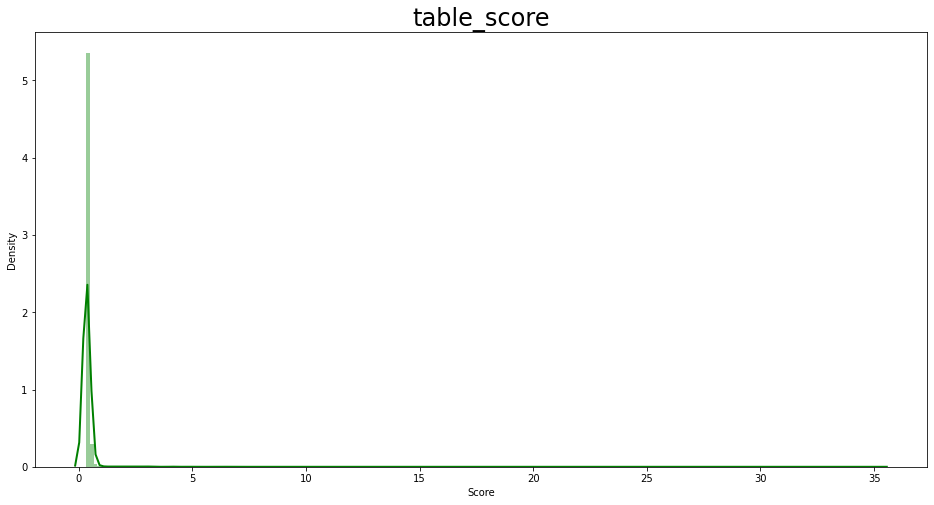

In [306]:
# Построим гистограмму распределения по столбцу Score
fig, ax = plt.subplots(figsize=(16,8))
sns.distplot(table_score['Score']
             , bins=200
             , color = 'green'
             , kde = True
             , kde_kws={'linewidth': 2}
             , )
plt.title('table_score', fontsize=24)
plt.show()

In [307]:
# Уберём выбросы и сделаем график нагляднее
t_s = table_score[table_score['Score'] < 0.345]

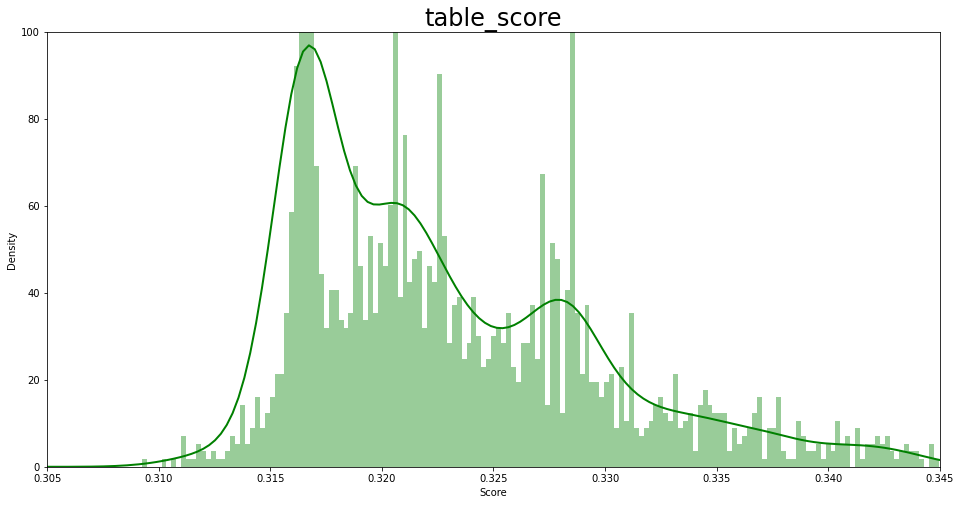

In [308]:
fig, ax = plt.subplots(figsize=(16,8))
sns.distplot(t_s['Score']
             , bins=200
             , color = 'green'
             , kde = True
             , kde_kws={'linewidth': 2}
             , )

plt.xlim(0.305,0.345), 
plt.ylim(0,100)

plt.title('table_score', fontsize=24)
plt.show()

In [332]:
# Добавим лучший получившийся результат на график распредлеления Score
best_res = 0.320

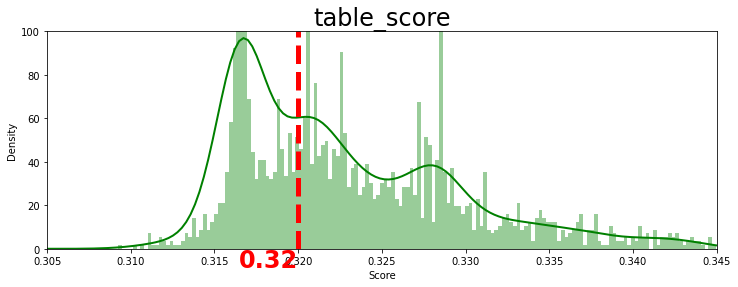

In [342]:
fig, ax = plt.subplots(figsize=(12,4))
sns.distplot(t_s['Score']
             , bins=200
             , color = 'green'
             , kde = True
             , kde_kws={'linewidth': 2}
             , )
plt.axvline(x=best_res, color='red', linestyle='--', label='Threshold', linewidth=5)
ax.text(best_res, 0.5, best_res, color='r', fontsize=24,
        ha='right', va='top', fontweight='bold')

plt.xlim(0.305,0.345), 
plt.ylim(0,100)

plt.title('table_score', fontsize=24)
plt.show()